# Facial Keypoint Detection
## Chandler McCann, Christopher Miller, Rohit Nair, Natarajan Shankar

This is the baseline for facial keypoint detection which is heavily borrowed from Daniel Nouri's excellent [tutorial](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/) which is a great starting point where to start our explorations.

_____

[Remove before submission]

Project setup is as below

    w207-final-project       -- base directory
        data                    -- data folder which contains the training and test data
        final_project.ipynb     -- python script


Moved the data outside so tht we can keep that and other artefacts that we don't want to commit outside of repo.

Loading required packages.

## Troubleshooting tips for why lasagne library is not loaded
first "import theano", then "git clone https://github.com/Lasagne/Lasagne.git", followed by "cd Lasagne" and then "sudo -H python setup.py install"

# W207 Final Project Code

In [1]:
# Telling matplotlib to plot graphs inline
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import time
from matplotlib import cm

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

import cPickle as pickle

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5103)


# STEP 1: UNDERSTAND THE PROBLEM
### 1. The goal is to detect 15 different keypoints on the face
### 2. 7049 training samples are available, some have NaN in attribute fields, needs to be cleaned up
### 3. Once cleaned up data is available, study the cleaned up data to see whether cleanup added value
### 4. Run PCA to narrow down the dimensionality
### 5. With narrowed dimensionality, train and predict using Neural nets 

# STEP 2: LOAD THE DATA AND DO BASIC CLEANUP

Loading train data and getting some information about its structure.

In [2]:
FTRAIN = 'data/training.csv'
FTEST = 'data/test.csv'

def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    # Just for the visual record, have the data printed out
    print(df.count())  # prints the number of values for each column
 
    # Get all the rows that have some NA fields
    dfna = df[df.isnull().any(axis=1)]

    # For the first level of processing, use only the records that have
    # complete data (no NaN)
    df = df.dropna()  # drop all rows that have missing values in them

    # Stick to 4 decimal points in order to have well formatted output
    # There are 2 dataframes
    #    df - dataframe with complete data
    #    dfna - dataframe with records that have NaN
    df.round(4)
    dfna.round(4)
    
    # Return processed data and the 2 dataframes
    return df, dfna


# Load the data
train_df, train_dfna = load()
test_df, test_dfna = load(test=True)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

## Additional Cleanup
### Dealing with rows that have NAs
#### 1. 4909 rows have NAs in some fields. These rows otherwise carry important information and this information in other columns must somehow be used. 
#### 2. 2140 rows have complete information and can used as a training set.
#### 3. The the field averages from the complete set and use the field averages to fill in and complete the set with NaNs
#### 4. This approach will provide a full 7049 rows if data that can be used for building predictive models.

In [3]:
# If true, program attempts to fix images with missing keypoints
include_errors = False

def repair_dataset(): 
    # How many rows have null features exist?
    dfnacheck_before = len(train_dfna[train_dfna.isnull().any(axis=1)])
    print("Rows with NA features before cleanup: %d" % dfnacheck_before)

    # Now compute the average of every column and use the averages to fill in the NaN fields in dfna
    for feature in train_dfna:
        if feature != 'Image':
            mean = train_df[feature].mean() * 1.0
            train_dfna[feature] = train_dfna[feature].fillna(mean)

    # Assert that all null features have been dealt with.
    dfnacheck_after = len(train_dfna[train_dfna.isnull().any(axis=1)])
    assert(dfnacheck_after == 0)
    print("Rows with NA features after cleanup: %d" % dfnacheck_after)

    # Merge the df and dfna dataframes together to create a much larger data set
    repaired = pd.concat([train_df, train_dfna])

    print("Size of corrected dataset: %d" % len(train_df2))
    return repaired

# Finish creating the data
def get_data(df, test=False, col=None):
    print(df.count())
    
    # Normalize the given data
    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48 # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
        
    else:
        y = None
    return X, y

if include_errors == True:
    repaired_df = repair_dataset()
    train_data, train_labels = get_data(repaired_df)
else:
    train_data, train_labels = get_data(train_df)
test_data, test_labels = get_data(test_df,test=True)

# Print out data boundaries
print("train_data.shape == {}; train_labels.min == {:.3f}; train_labels.max == {:.3f}".format(
        train_data.shape, train_data.min(), train_data.max()))
print("train_labels.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
        train_labels.shape, train_labels.min(), train_labels.max()))

left_eye_center_x            2140
left_eye_center_y            2140
right_eye_center_x           2140
right_eye_center_y           2140
left_eye_inner_corner_x      2140
left_eye_inner_corner_y      2140
left_eye_outer_corner_x      2140
left_eye_outer_corner_y      2140
right_eye_inner_corner_x     2140
right_eye_inner_corner_y     2140
right_eye_outer_corner_x     2140
right_eye_outer_corner_y     2140
left_eyebrow_inner_end_x     2140
left_eyebrow_inner_end_y     2140
left_eyebrow_outer_end_x     2140
left_eyebrow_outer_end_y     2140
right_eyebrow_inner_end_x    2140
right_eyebrow_inner_end_y    2140
right_eyebrow_outer_end_x    2140
right_eyebrow_outer_end_y    2140
nose_tip_x                   2140
nose_tip_y                   2140
mouth_left_corner_x          2140
mouth_left_corner_y          2140
mouth_right_corner_x         2140
mouth_right_corner_y         2140
mouth_center_top_lip_x       2140
mouth_center_top_lip_y       2140
mouth_center_bottom_lip_x    2140
mouth_center_b

## For data visualization, need a plot routine
### Copy the plot code as published in 
https://www.ischool.berkeley.edu/sites/default/files/projects/14-dailey_jang_oneto_yang_final.pdf

Display some sample images with their keypoints:


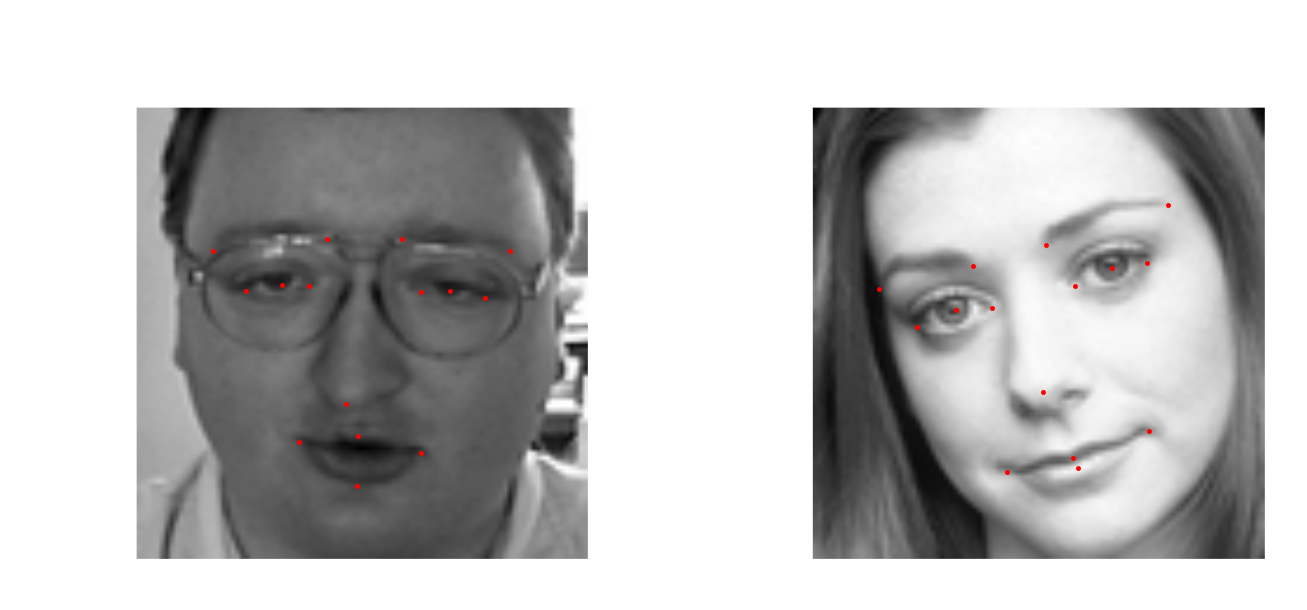

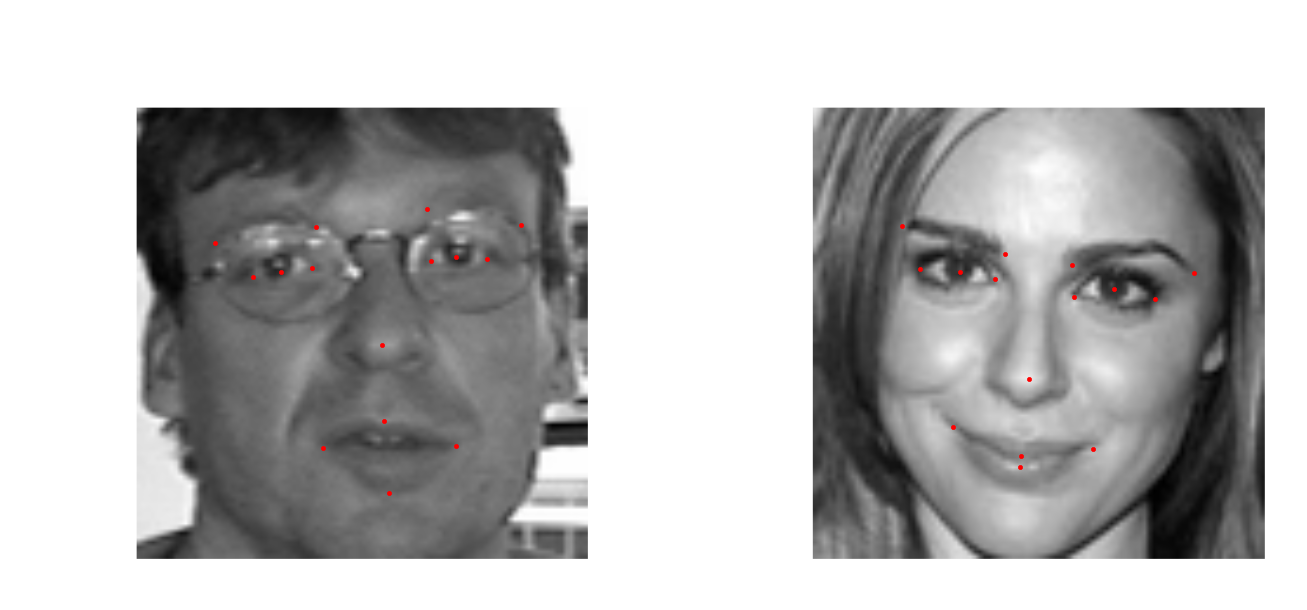

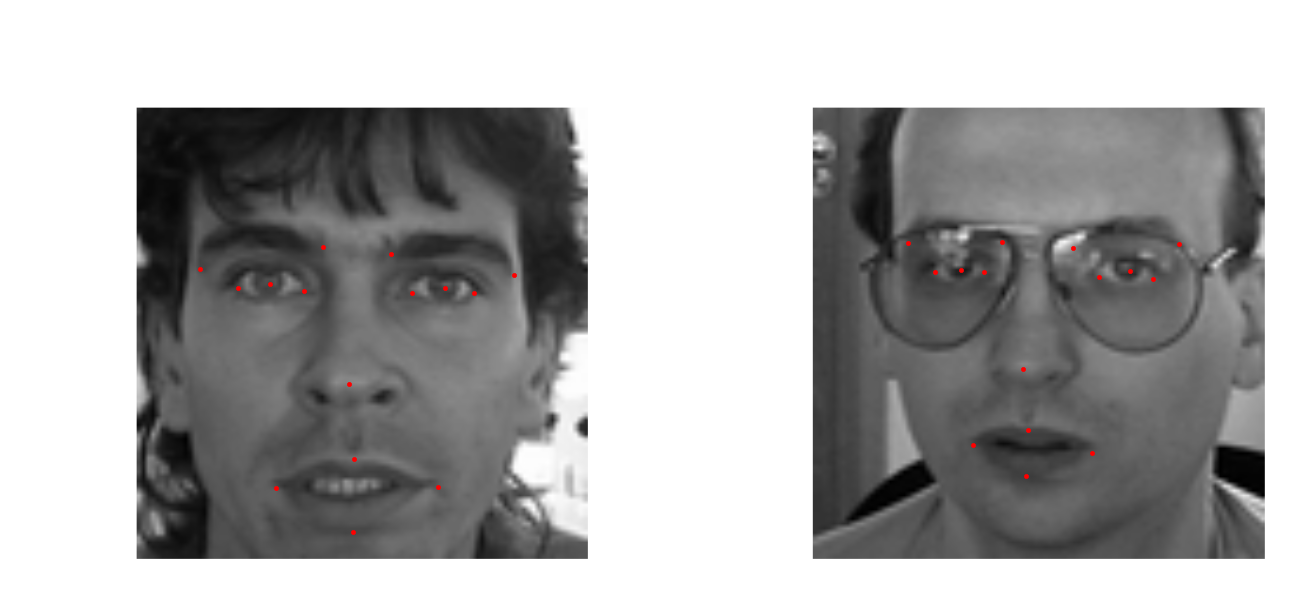

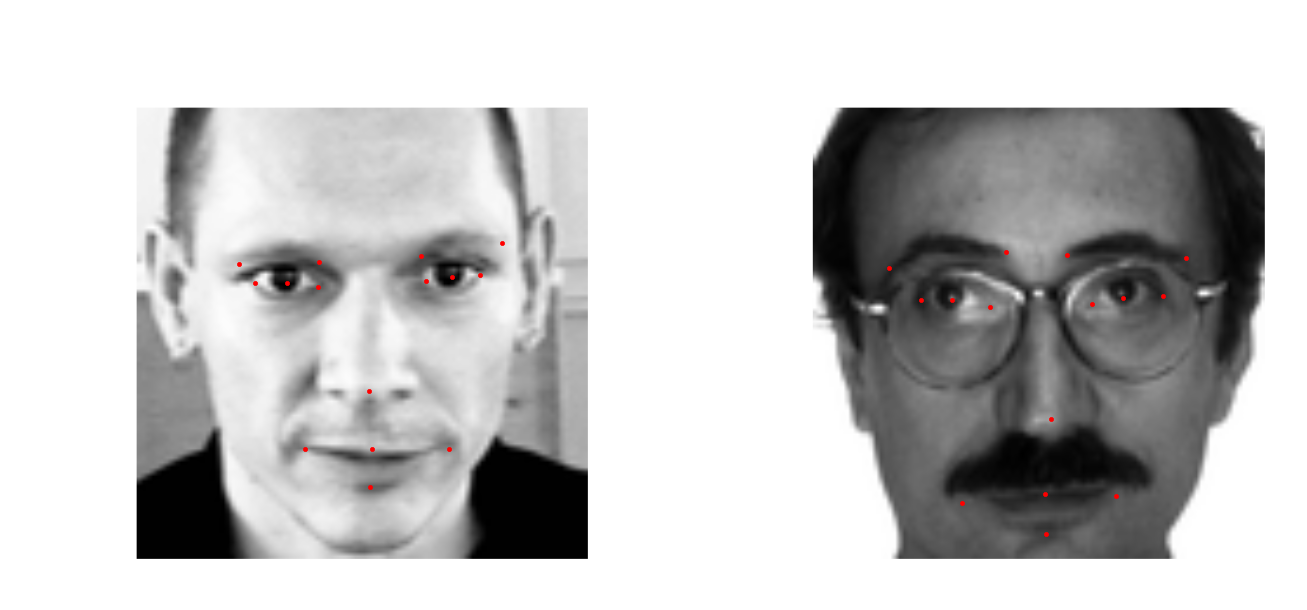

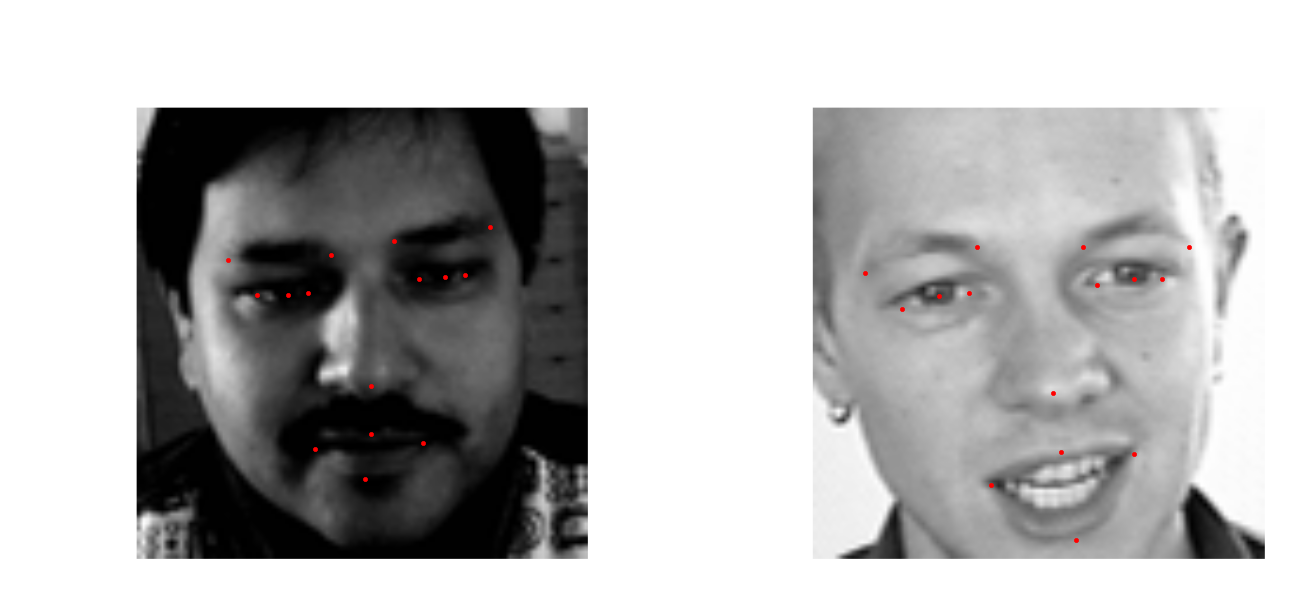

In [4]:
def compare_images(image1, p1, image2, p2): 
    p1 = p1 * 48 + 48
    p2 = p2 * 48 + 48
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1) 
    plt.imshow(np.reshape(image1,(96,96)), cmap = cm.gray) 
    for x, y in np.reshape(p1,(len(p1)/2, 2)):
        plt.plot(x, y, 'r.')
    plt.axis('off')
    plt.subplot(1,2,2) 
    plt.imshow(np.reshape(image2,(96,96)), cmap = cm.gray) 
    for x, y in np.reshape(p2,(len(p2)/2, 2)):
        plt.plot(x, y, 'r.')
    plt.axis('off')

# Keep data consistent.
np.random.seed(0)
sample = np.floor(np.random.rand(5, 2) * len(train_data))

print("Display some sample images with their keypoints:")
for i in sample:
    compare_images(train_data[i[0]], train_labels[i[0]], train_data[i[1]], train_labels[i[1]])


## STEP 3 : Start with a simple neural network to predict 

Plotting how well the neural net works with no preprocessing by looking at training loss.


# Neural Network with 924730 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input     9216
  1  hidden     100
  2  output      30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.19016     0.05962    3.18942  0.07s
      2     0.04155     0.03219    1.29080  0.06s
      3     0.02281     0.02033    1.12184  0.06s
      4     0.01437     0.01444    0.99552  0.07s
      5     0.01232     0.01319    0.93391  0.06s
      6     0.01157     0.01244    0.92965  0.06s
      7     0.01101     0.01190    0.92476  0.06s
      8     0.01057     0.01149    0.92042  0.06s
      9     0.01022     0.01112    0.91936  0.06s
     10     0.00991     0.01079    0.91909  0.06s
     11     0.00965     0.01050    0.91890  0.06s
     12     0.00941     0.01024    0.91858  0.06s
     13     0.00920     0.01001    0.91846  0.06s
     14     0.00900     0.00980    0.91847  0.06s
     15     0.00882     0.00

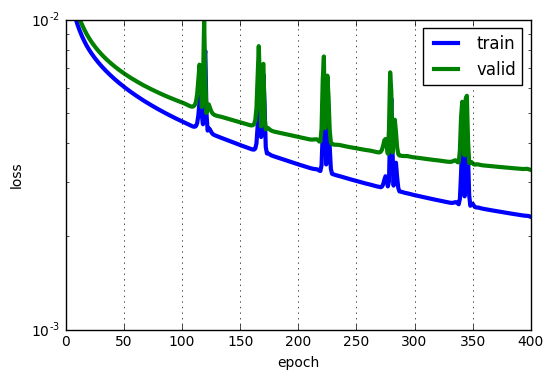

In [13]:
def graph_results(net):
    train_loss = np.array([i["train_loss"] for i in net.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
    plt.plot(train_loss, linewidth=3, label="train")
    plt.plot(valid_loss, linewidth=3, label="valid")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.ylim(1e-3, 1e-2)
    plt.yscale("log")
    plt.show()

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=400,  # we want to train this many epochs
    verbose=1,
    )

net1.fit(train_data, train_labels)
graph_results(net1)

In [14]:
# Print RMSE
print("RMSE: %f" % (np.sqrt(0.00328) * 48))

RMSE: 2.749022


# Data Adjustment: Algorithm # 1
### Histogram Stretching
A simple way of image enhancement that improves the contrast in an image by stretching the range of pixel intensity to span the entire range from minimum (0) to maximum (1). Over 8 bits, this algorithm expands the contrast in the image over the entire 0 to 255 range

The reference article is:
http://cs229.stanford.edu/proj2014/Yue%20Wang,Yang%20Song,Facial%20Keypoints%20Detection.pdf
#### Ref: Facial Keypoints Detection, by Yue Wang and Yang Song, Stanford University

Finished stretching train_data in 308.971874 seconds


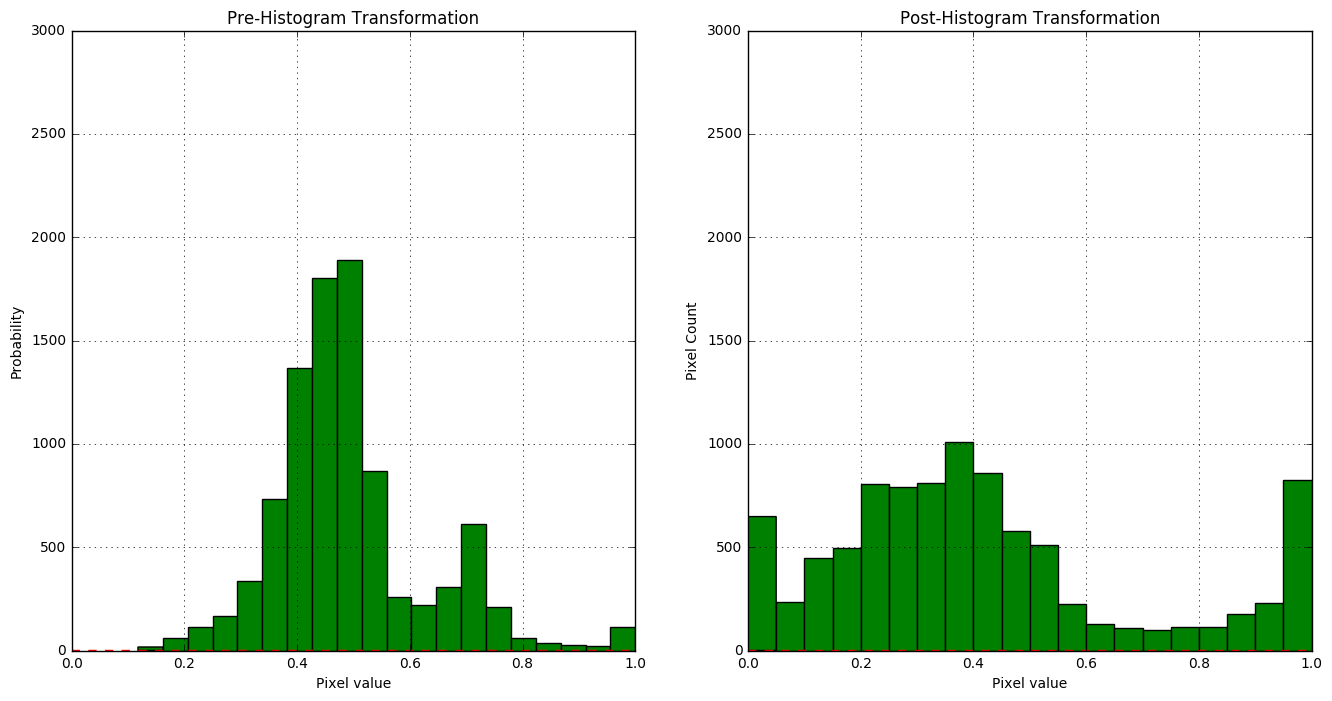

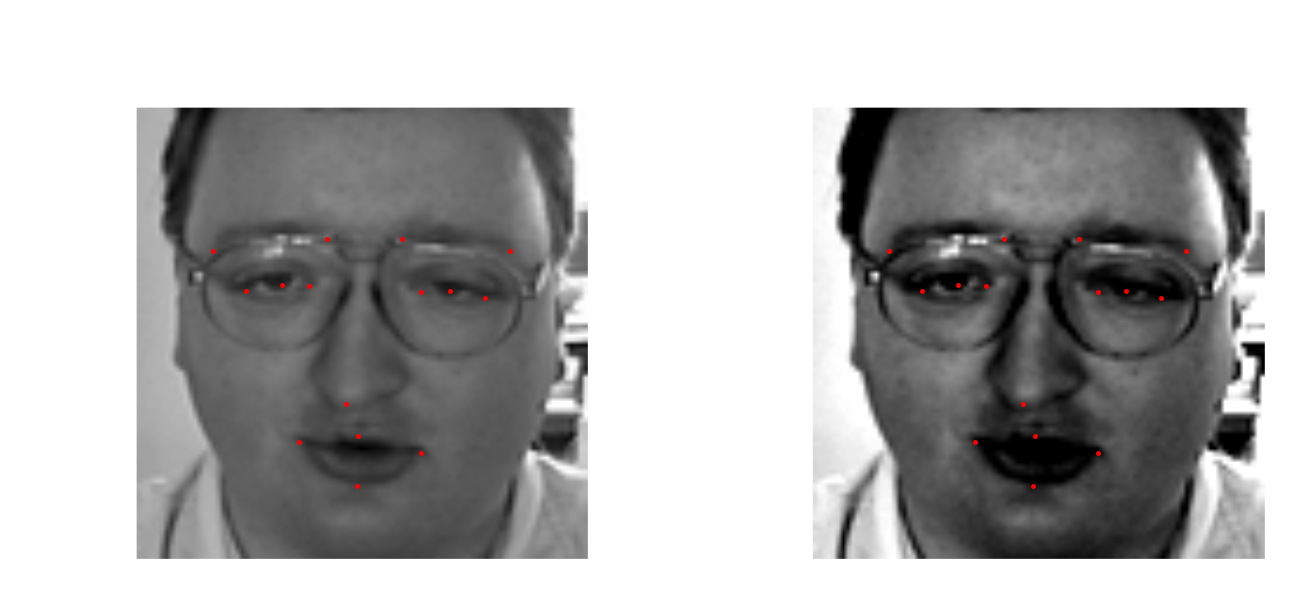

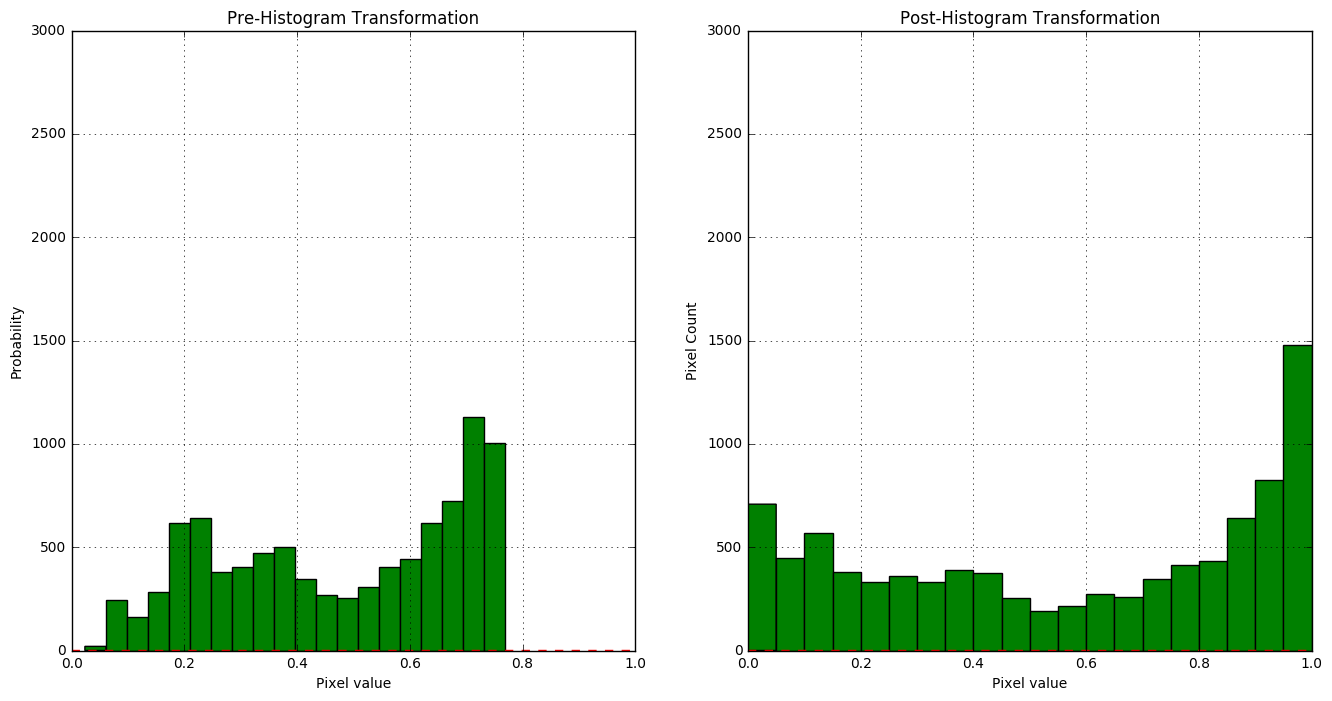

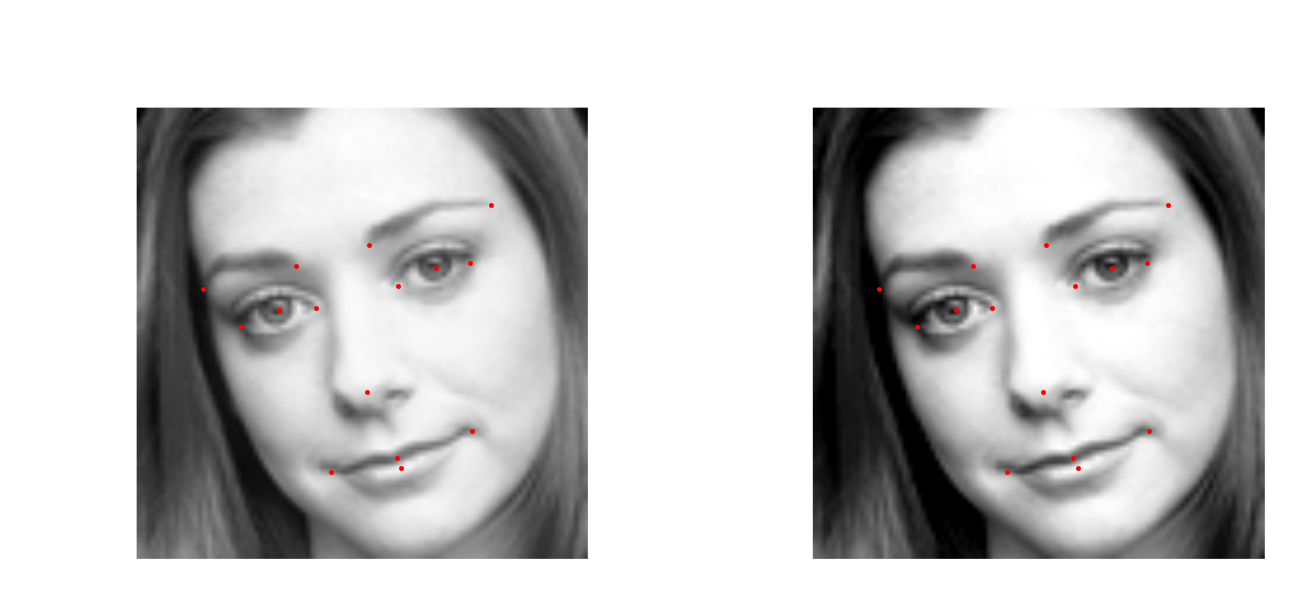

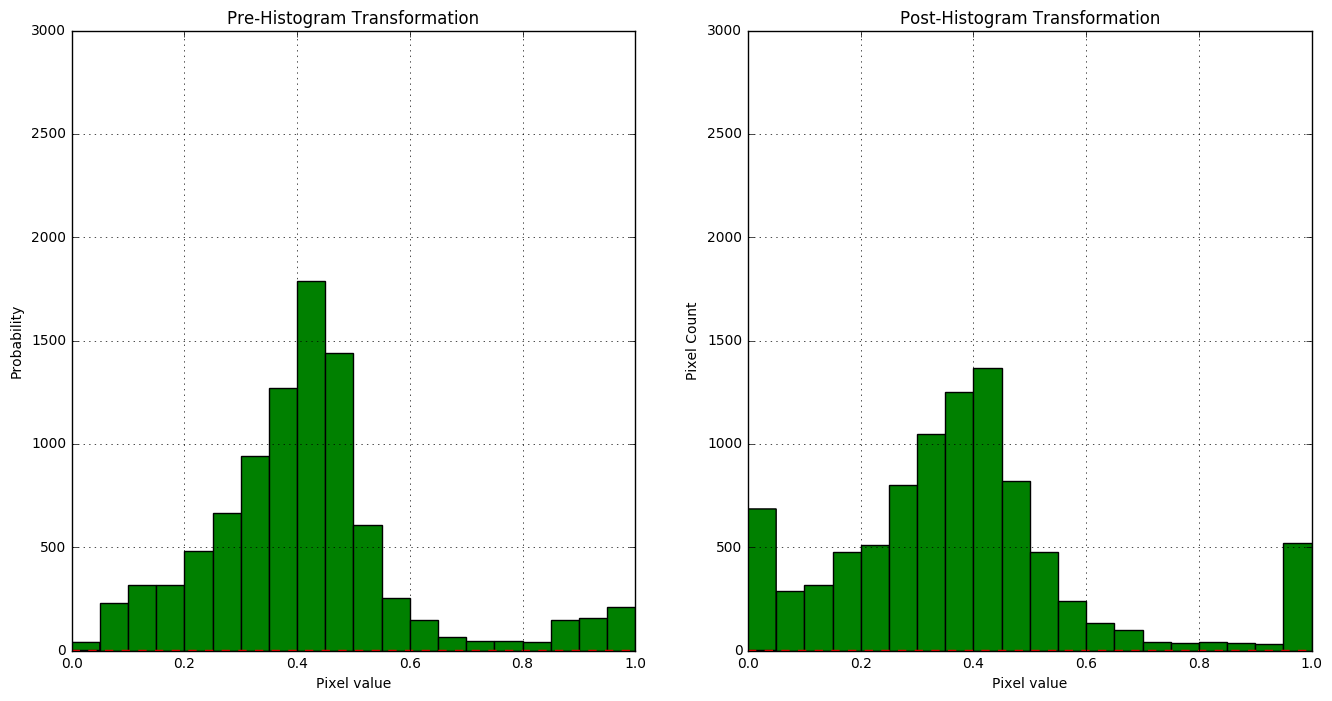

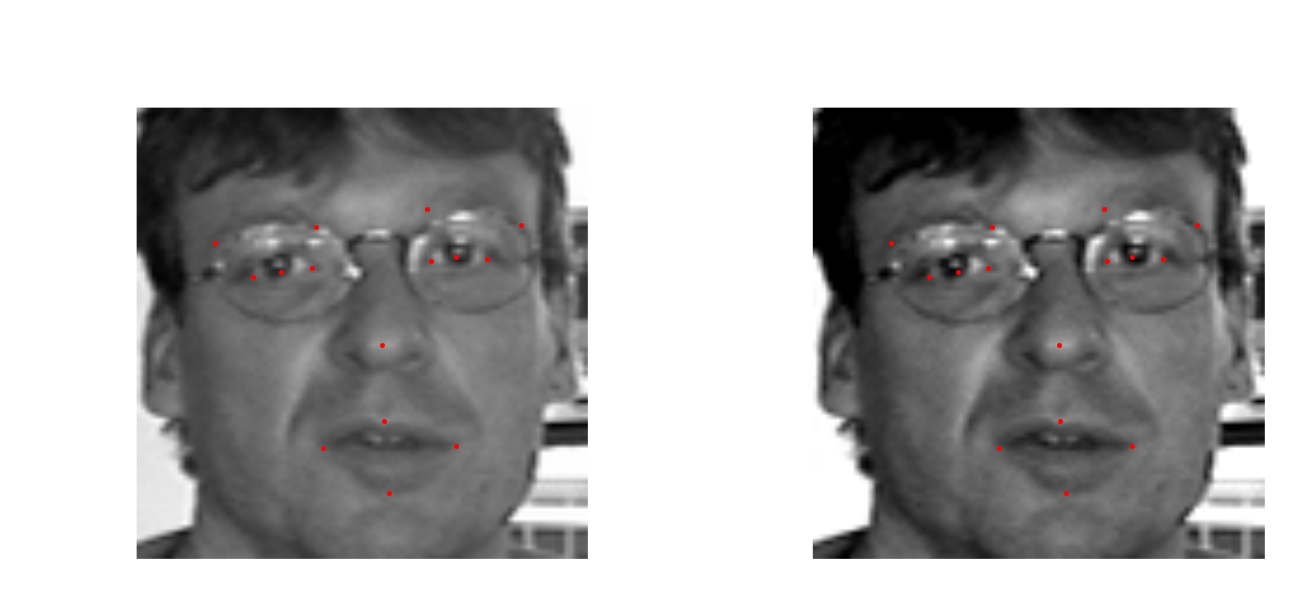

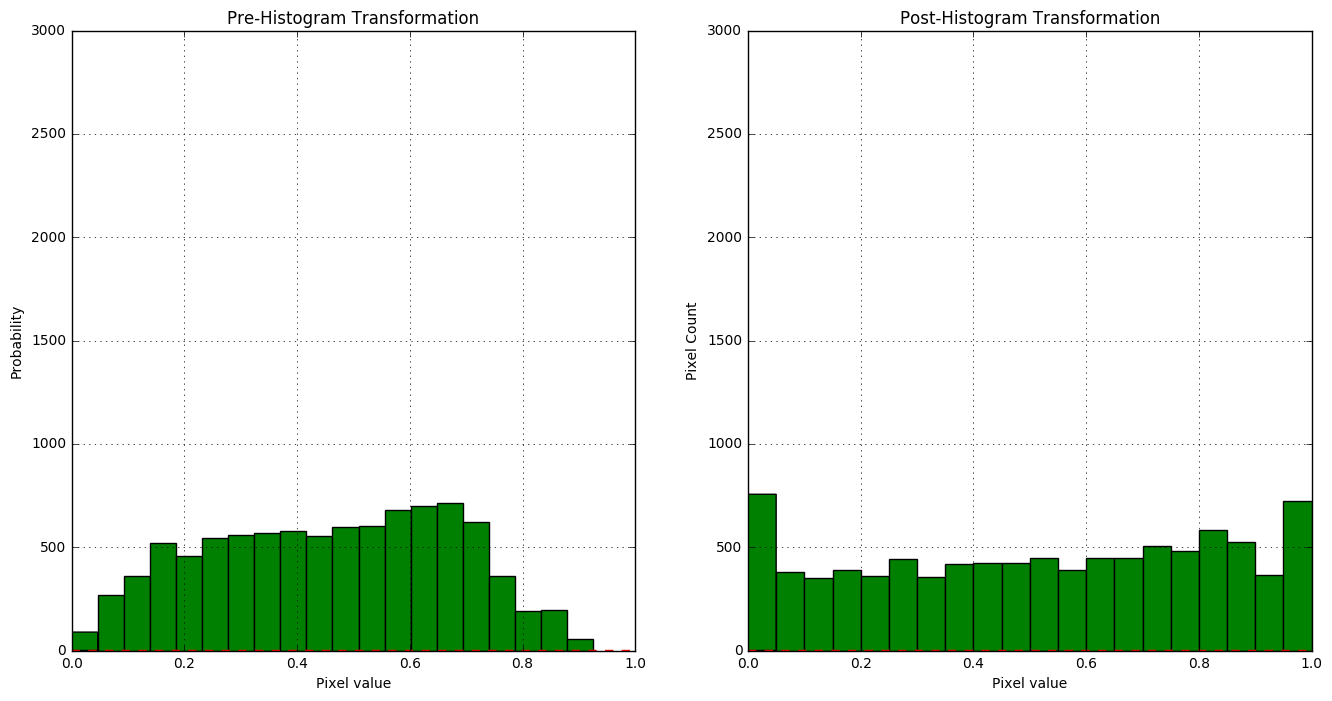

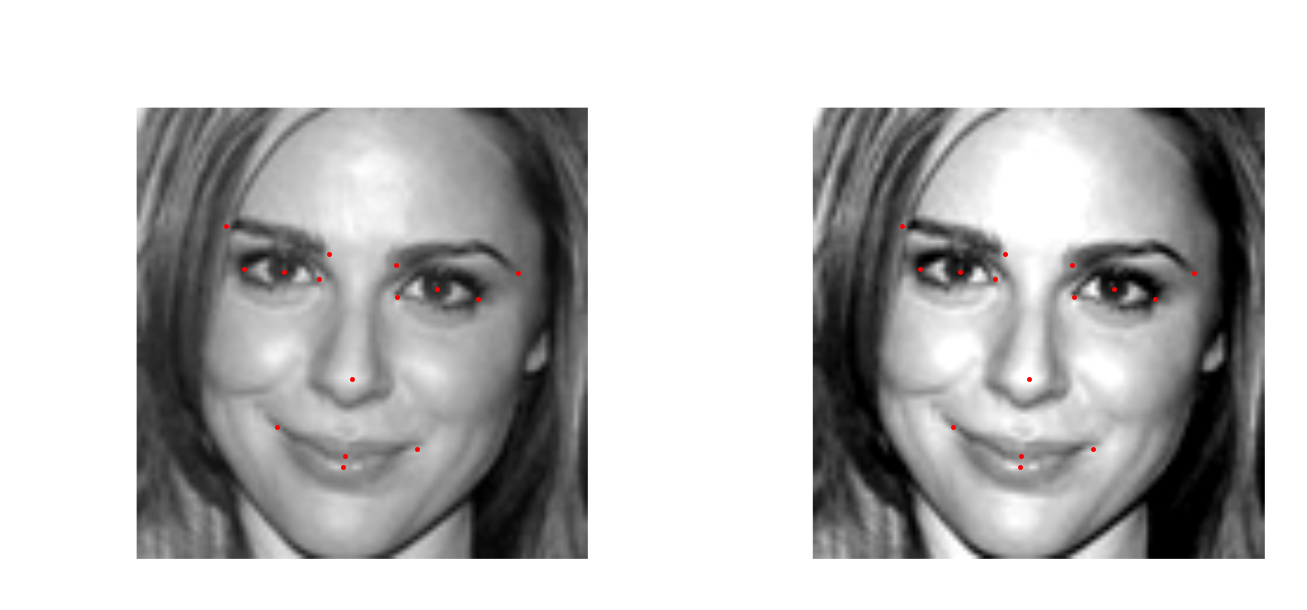

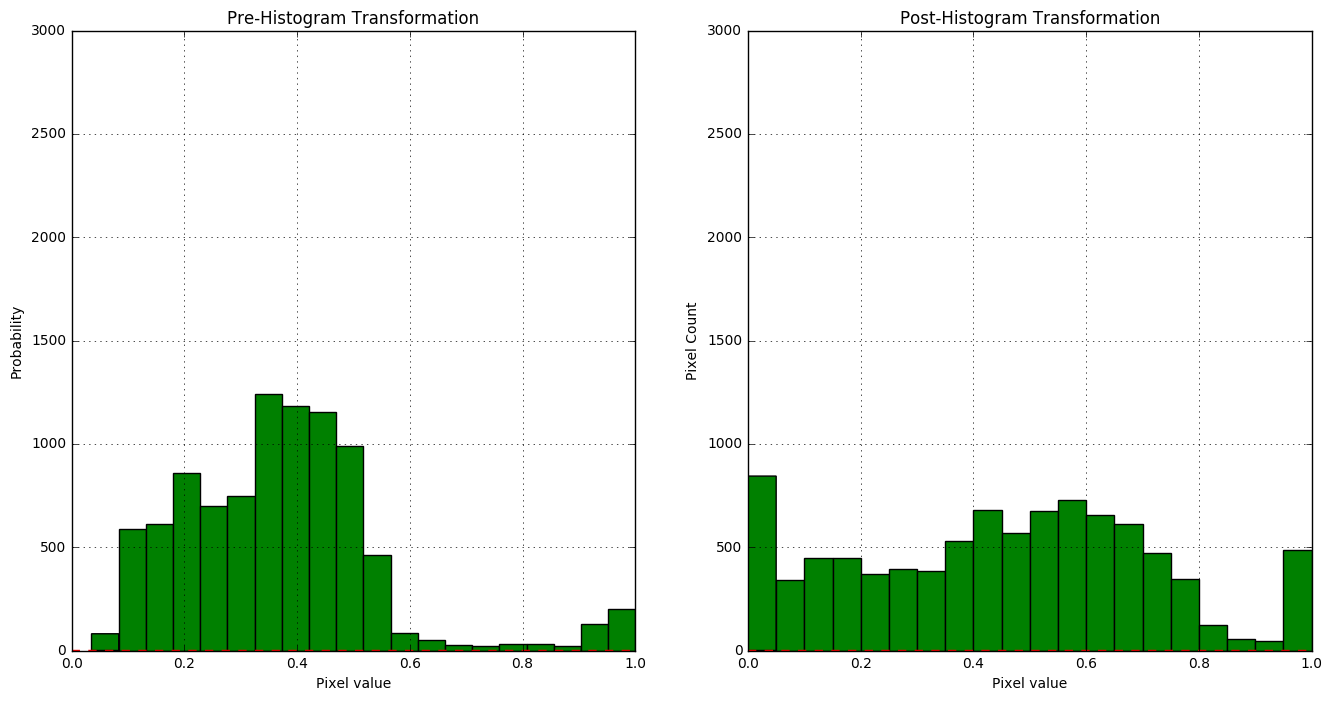

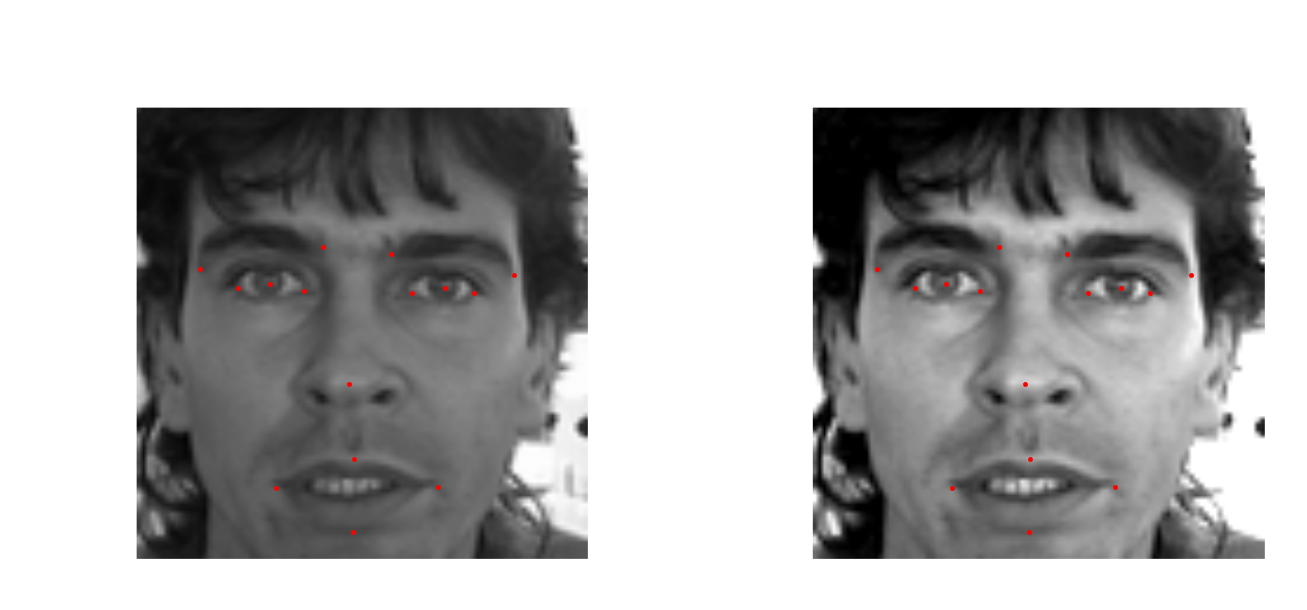

In [43]:
def compare_histograms(frame1, frame2):
        fig = plt.figure(figsize=(16,8))
        # the histogram of the data
        fig.add_subplot(1,2,1)
        n, bins, patches = plt.hist(frame1, 20, facecolor='green')
        l = plt.plot(bins, 'r--', linewidth=1)

        plt.xlabel('Pixel value')
        plt.ylabel('Probability')
        plt.title('Pre-Histogram Transformation')
        plt.axis([0, 1, 0, 3000])
        plt.grid(True)

        fig.add_subplot(1,2,2)
        n, bins, patches = plt.hist(frame2, 20, facecolor='green')
        l = plt.plot(bins, 'r--', linewidth=1)

        plt.xlabel('Pixel value')
        plt.ylabel('Pixel Count')
        plt.title('Post-Histogram Transformation')
        plt.axis([0, 1, 0, 3000])
        plt.grid(True)


def stretch_histogram(frame):
    # Save the incoming 
    new_frame = []
    
    # Algorithm is very sensitive to outliers at both ends
    # So, focus on the 5th and 95th percentile points as as proposed by Song et al.
    a = np.percentile(frame, 5)
    b = np.percentile(frame, 95)
    u = 1 # desired_max_pixel_value
    l = 0 # desired_min_pixel_value

    # Algorithm fails to optimize if low and high values are at the extreme
    if a == 0 and b == 1:
        return(frame)
    
    # If frame is all white or all black, skip processing
    if a == 1 or b == 0:
        return(frame)

    for x in range(0, len(frame)):
        if (frame[x] > b):
            new_frame.append(np.float32(1.0))
        elif (frame[x] < a):
            new_frame.append(np.float32(0.0))
        else:
            p_prime = np.float32(((u - l) / (b - a)) * (frame[x] - a) - l)
            new_frame.append(p_prime)
            if (p_prime < 0) | (p_prime > 1):
                print(x, p_prime)
    
    return np.array(new_frame).astype(np.float32)

# Keep data consistent.
np.random.seed(0)
sample = np.random.rand(5) * len(train_data)

for i in sample:
    before = train_data[i]
    after = stretch_histogram(train_data[i])
    compare_histograms(before, after)
    compare_images(before, train_labels[i], after, train_labels[i])

# Looks like everything is working well, generate the new set of data to go forward with
start = time.time()
train_stretched = np.array(map(stretch_histogram, train_data))
print("Finished stretching train_data in %4f seconds" % (time.time() - start))
start = time.time()

## Testing improvement with Histogram Stretching

See how the model improved by increasing contrast

# Neural Network with 924730 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input     9216
  1  hidden     100
  2  output      30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.28717     0.09140    3.14209  0.07s
      2     0.07386     0.04774    1.54704  0.06s
      3     0.04096     0.02055    1.99270  0.06s
      4     0.01560     0.01778    0.87776  0.06s
      5     0.01263     0.01412    0.89435  0.06s
      6     0.01036     0.01001    1.03580  0.06s
      7     0.00982     0.00950    1.03356  0.06s
      8     0.00872     0.00889    0.98111  0.06s
      9     0.00801     0.00846    0.94679  0.06s
     10     0.00767     0.00817    0.93887  0.06s
     11     0.00741     0.00787    0.94224  0.06s
     12     0.00721     0.00767    0.93916  0.06s
     13     0.00704     0.00751    0.93726  0.06s
     14     0.00690     0.00736    0.93656  0.06s
     15     0.00677     0.00

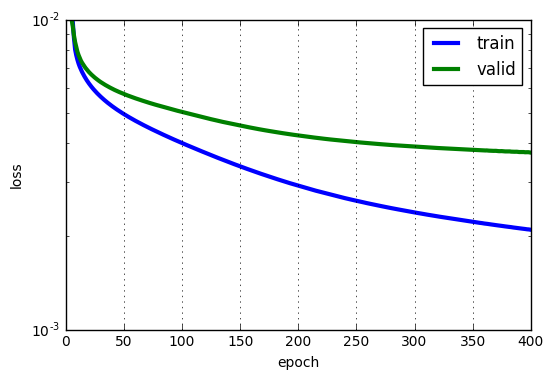

In [17]:
net2 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=400,  # we want to train this many epochs
    verbose=1,
    )

net2.fit(train_stretched, train_labels)

graph_results(net2)

In [18]:
# Print RMSE
print("RMSE: %f" % (np.sqrt(0.00373) * 48))

RMSE: 2.931539


## Data Adjustment: Algorithm # 2
### Histogram Shifting
A simple way of image enhancement that improves the contrast in an image by shifting the intensity of the pixels to the right. Lighter pixels are darker and darker pixels are enhanced. 
The reference article is: www.tutorialspoint.com

Finished shifting train_data in 64.511058 seconds


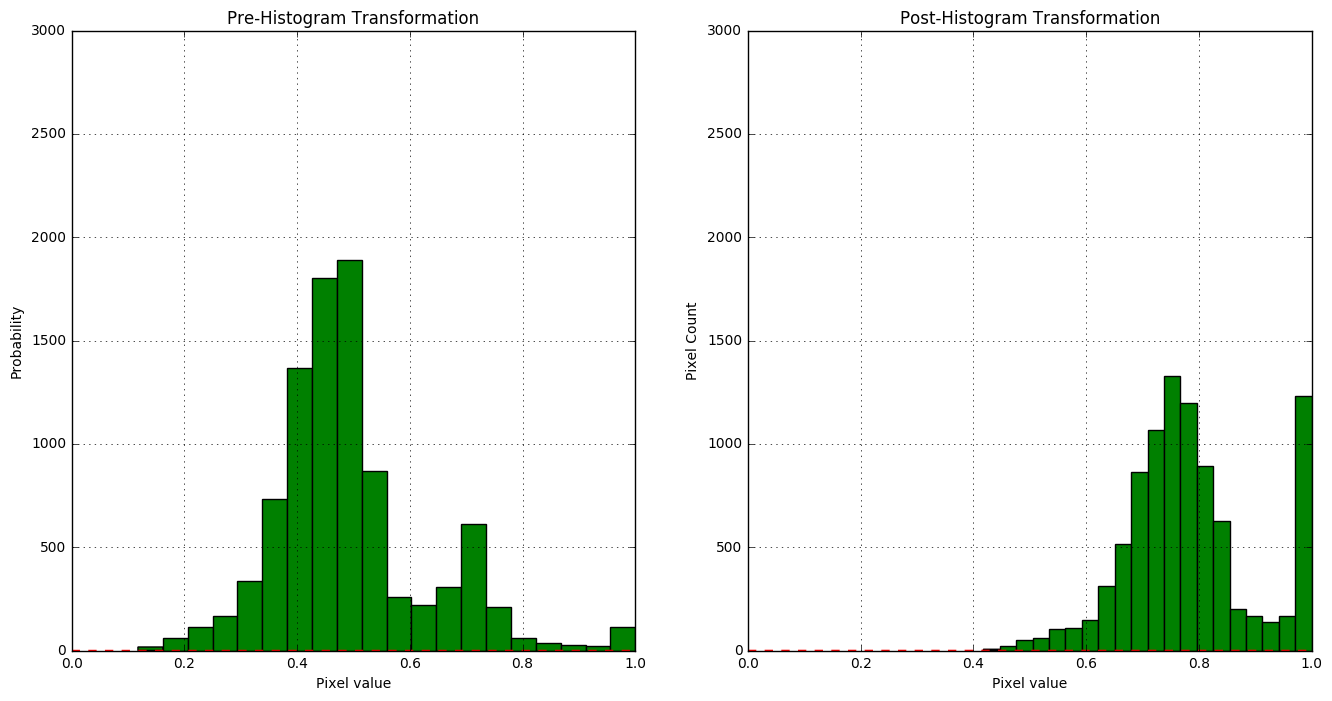

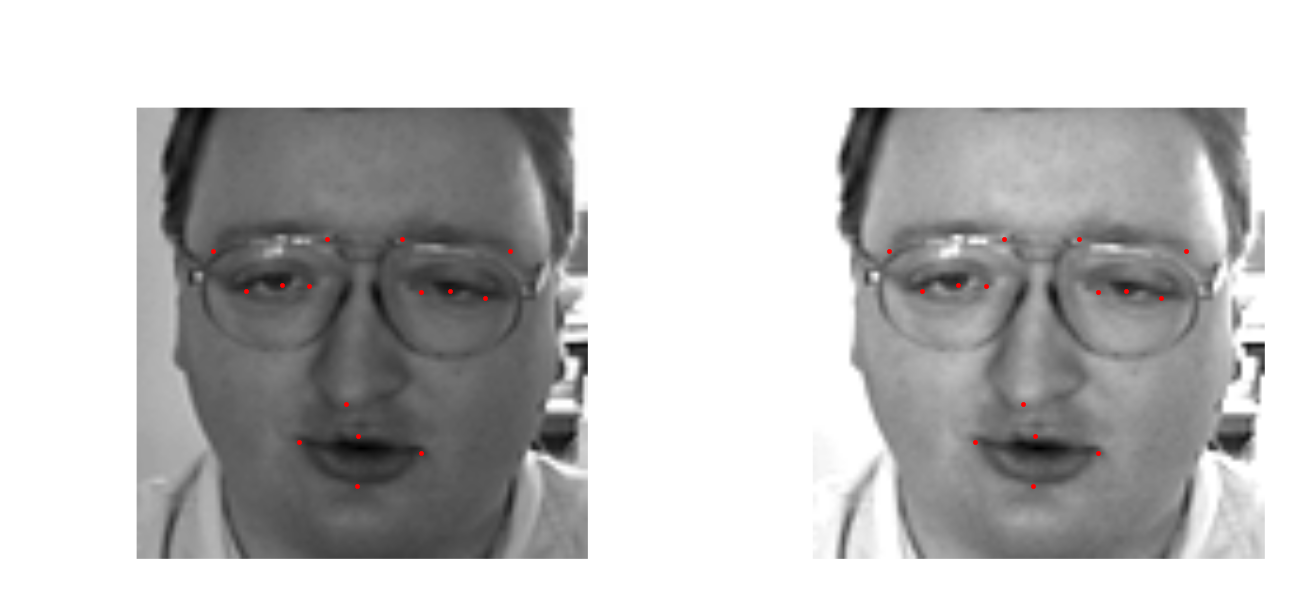

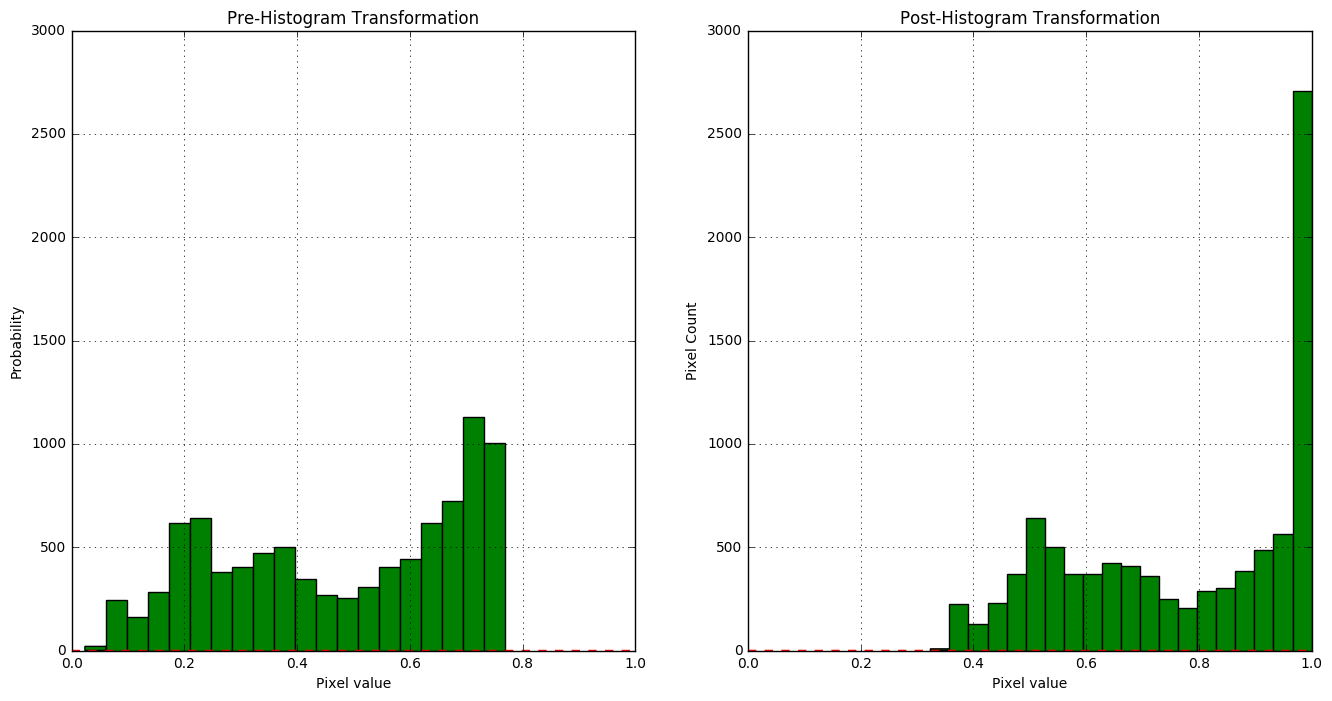

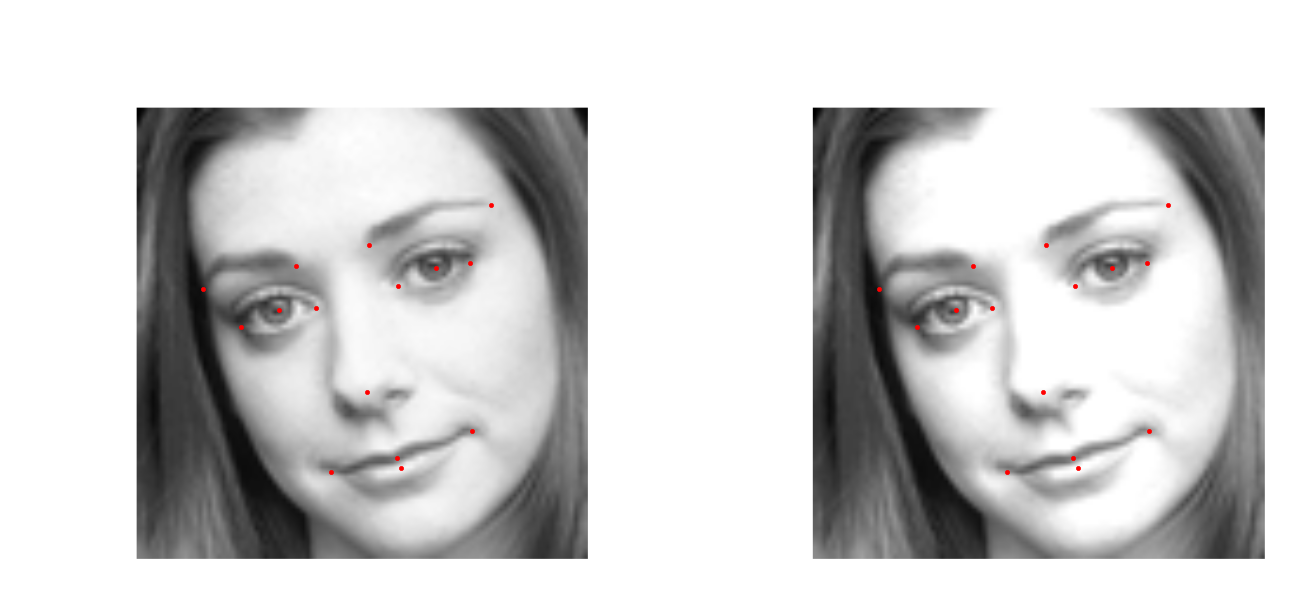

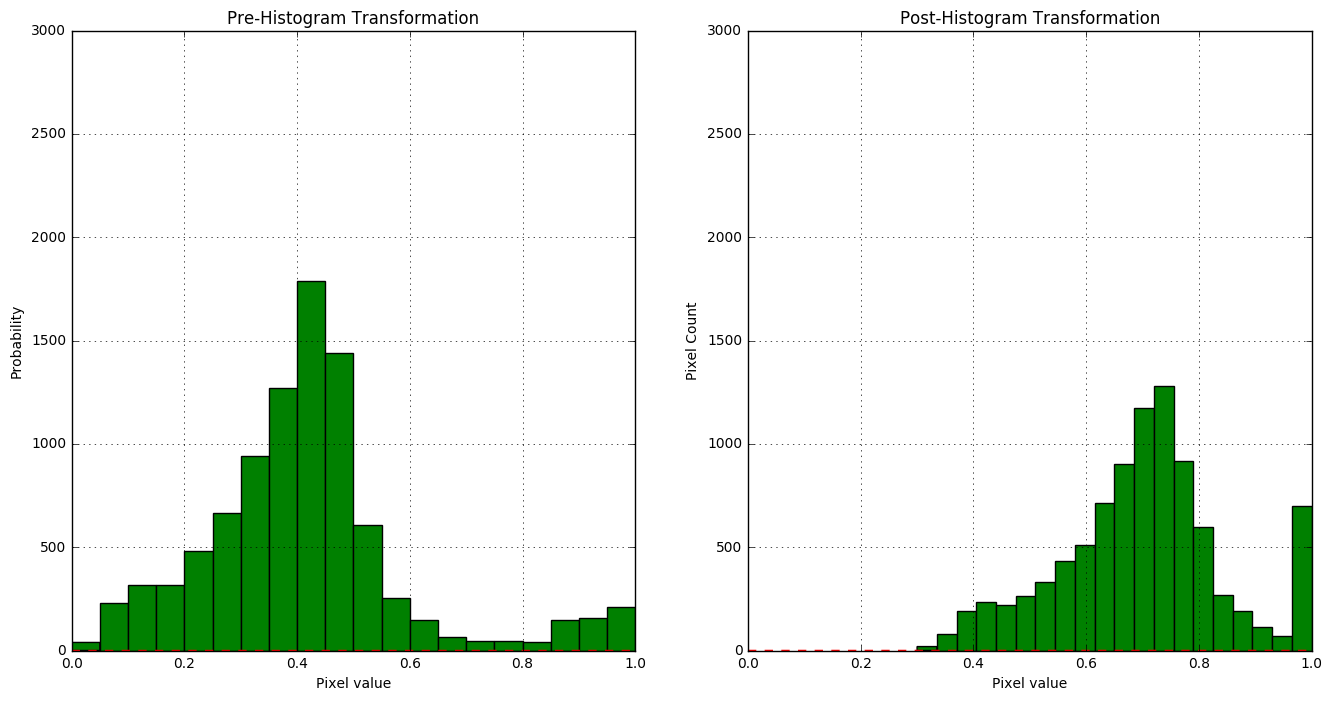

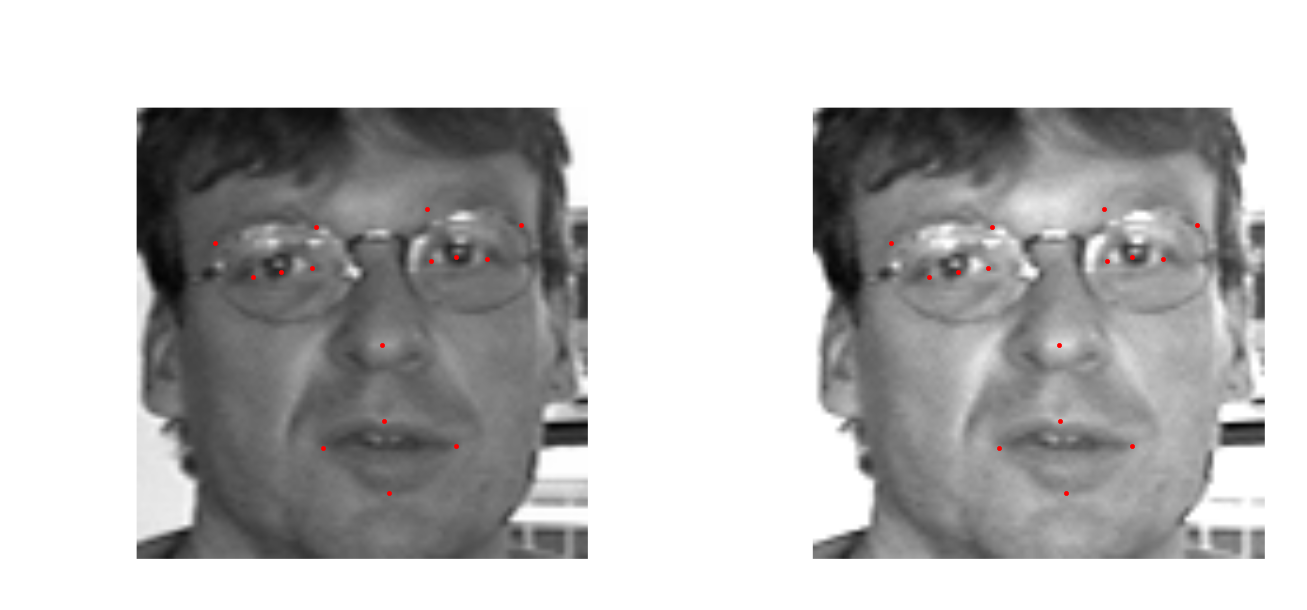

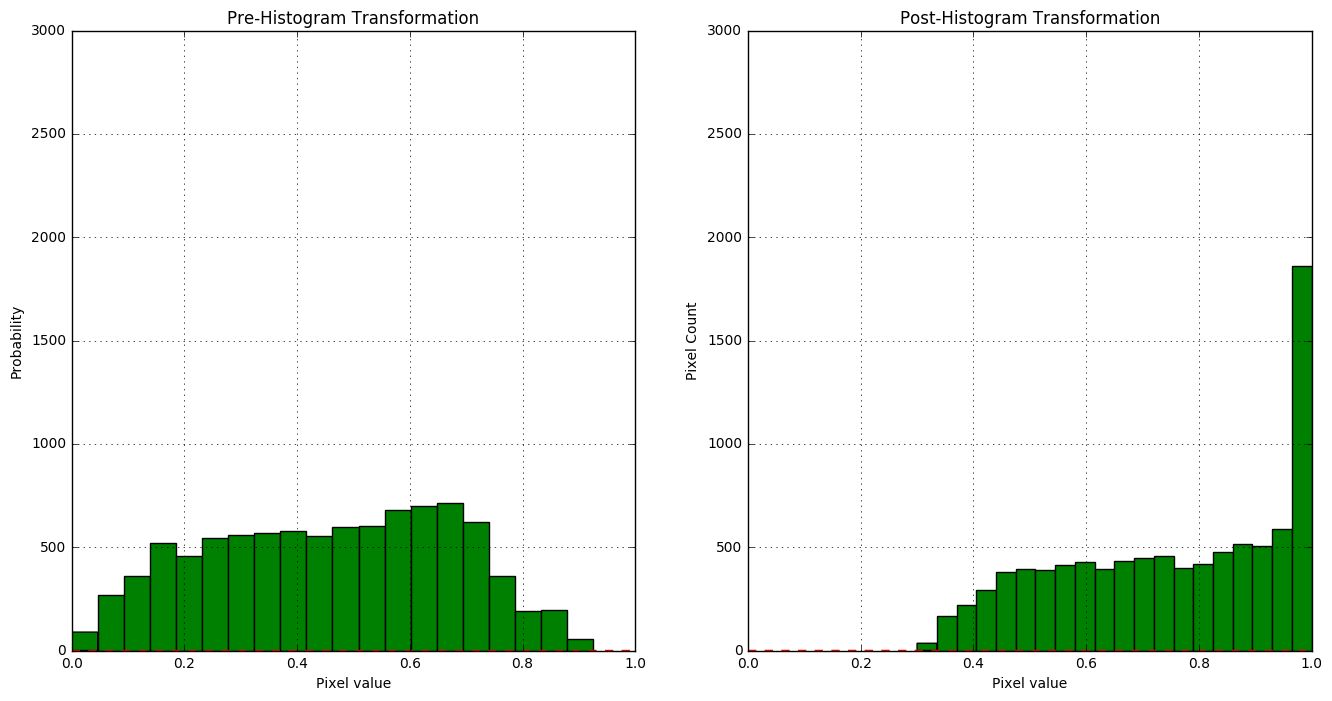

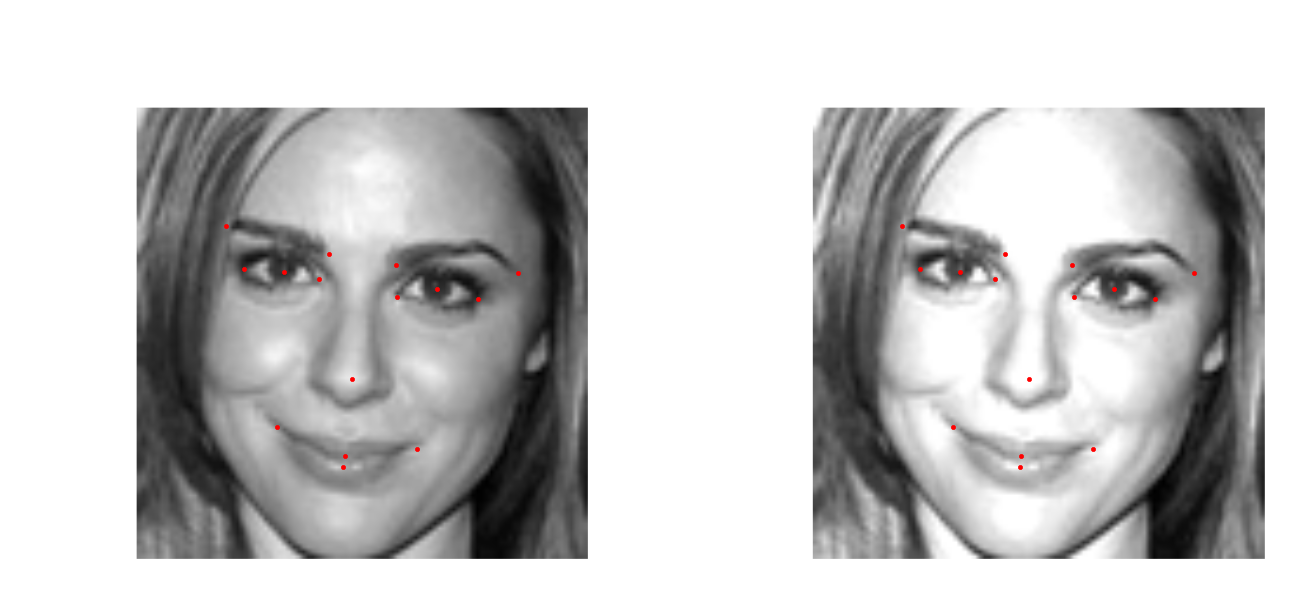

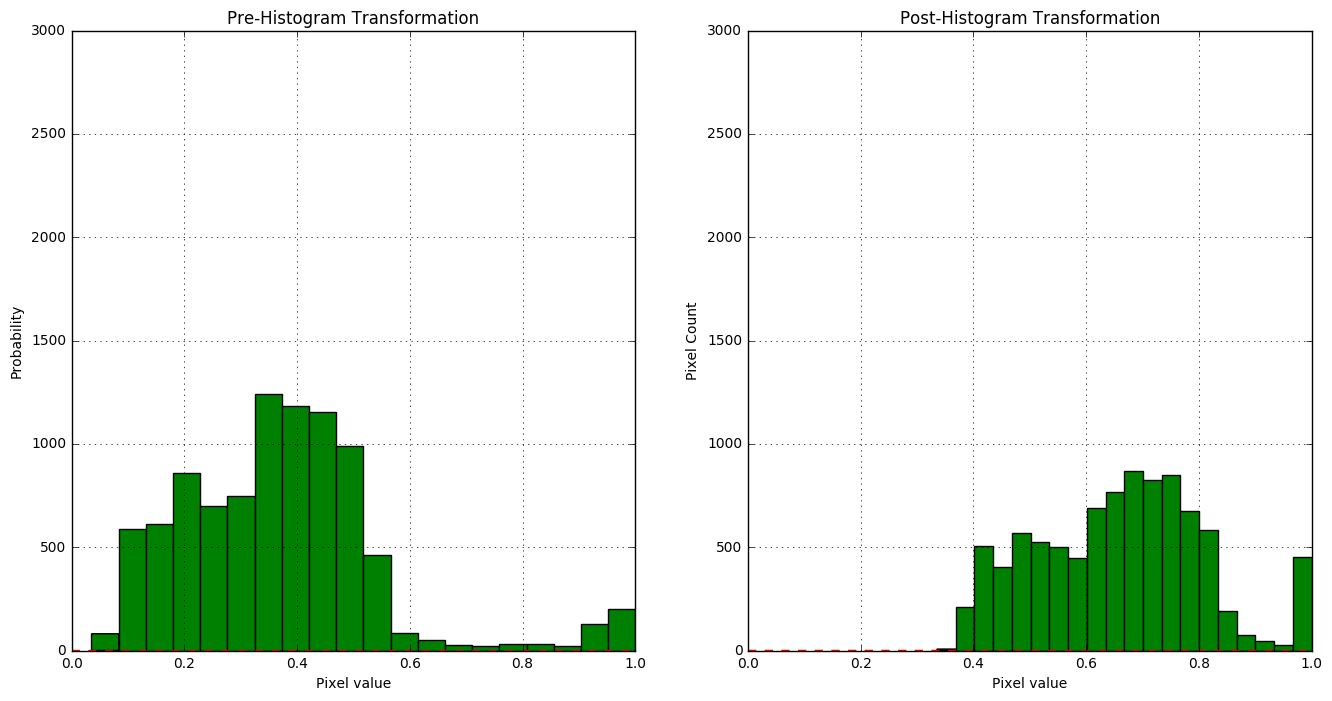

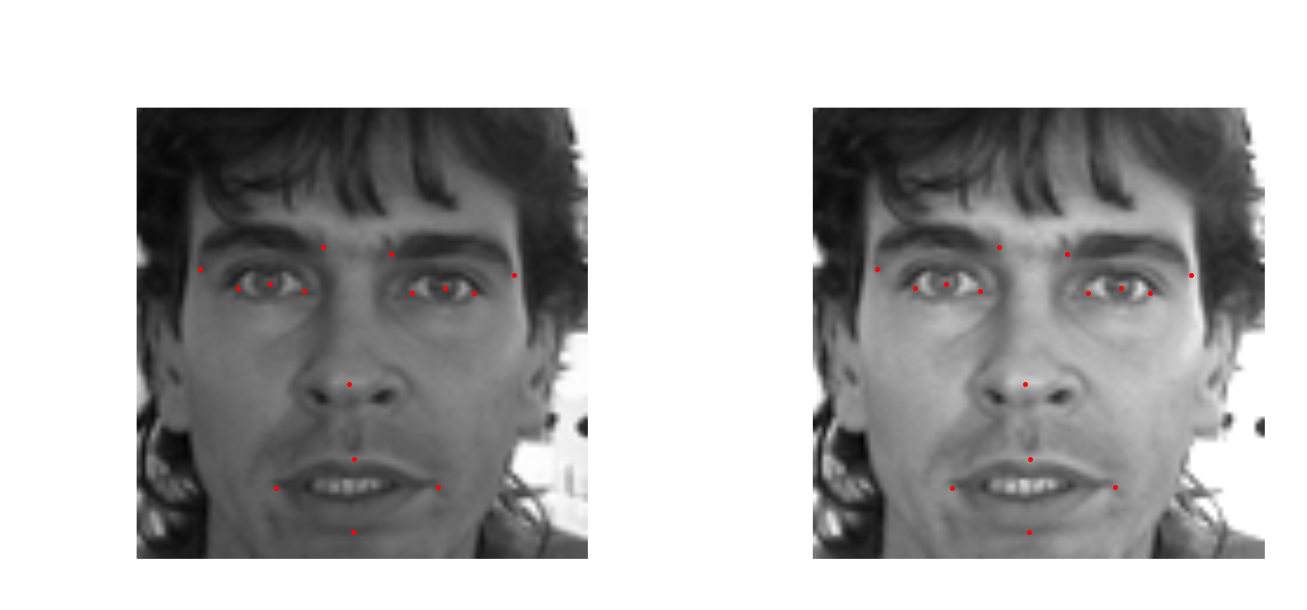

In [19]:
# Load data and shift
def shift_histogram(frame):
    shift = 0.30
    new_frame = []
       
    for i in range(0, len(frame)):
        new_value = frame[i] + shift
        if new_value > 1.0:
            new_frame.append(np.float64(1.0))
        else:
            new_frame.append(new_value)
    
    return np.array(new_frame).astype(np.float32)


# Keep data consistent.
np.random.seed(0)
sample = np.random.rand(5) * len(train_data)

for i in sample:
    before = train_data[i]
    after = shift_histogram(train_data[i])
    compare_histograms(before, after)
    compare_images(before, train_labels[i], after, train_labels[i])

# Looks like everything is working well, generate the new set of data to go forward with
start = time.time()
train_shift = np.array(map(shift_histogram, train_data))
print("Finished shifting train_data in %4f seconds" % (time.time() - start))

## Testing improvement with Histogram Shifting

See how the model improved by increasing brightness


# Neural Network with 924730 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input     9216
  1  hidden     100
  2  output      30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.68598     0.13885    4.94044  0.07s
      2     0.13009     0.11576    1.12382  0.06s
      3     0.10470     0.09831    1.06501  0.06s
      4     0.08854     0.07739    1.14416  0.06s
      5     0.06688     0.05595    1.19541  0.06s
      6     0.04259     0.02953    1.44217  0.06s
      7     0.02074     0.01466    1.41487  0.06s
      8     0.01103     0.01119    0.98527  0.06s
      9     0.00899     0.01048    0.85764  0.06s
     10     0.00690     0.00623    1.10692  0.06s
     11     0.00519     0.00521    0.99742  0.06s
     12     0.00501     0.00507    0.98771  0.06s
     13     0.00496     0.00503    0.98773  0.06s
     14     0.00493     0.00499    0.98672  0.06s
     15     0.00489     0.00

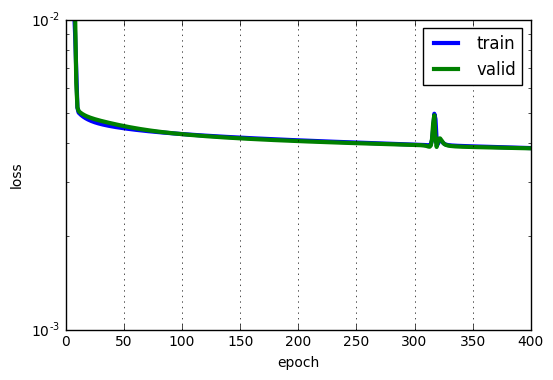

In [20]:
net3 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=400,  # we want to train this many epochs
    verbose=1,
    )

net3.fit(train_shift, train_labels)
graph_results(net3)

In [22]:
# Print RMSE
print("RMSE: %f" % (np.sqrt(0.00384) * 48))

RMSE: 2.974451


## More augmentation

### Gaussian Blur

Gaussian Blur changes cell values to a weighted average of surrounding cells.  

Finished blurring train_data in 499.317690 seconds


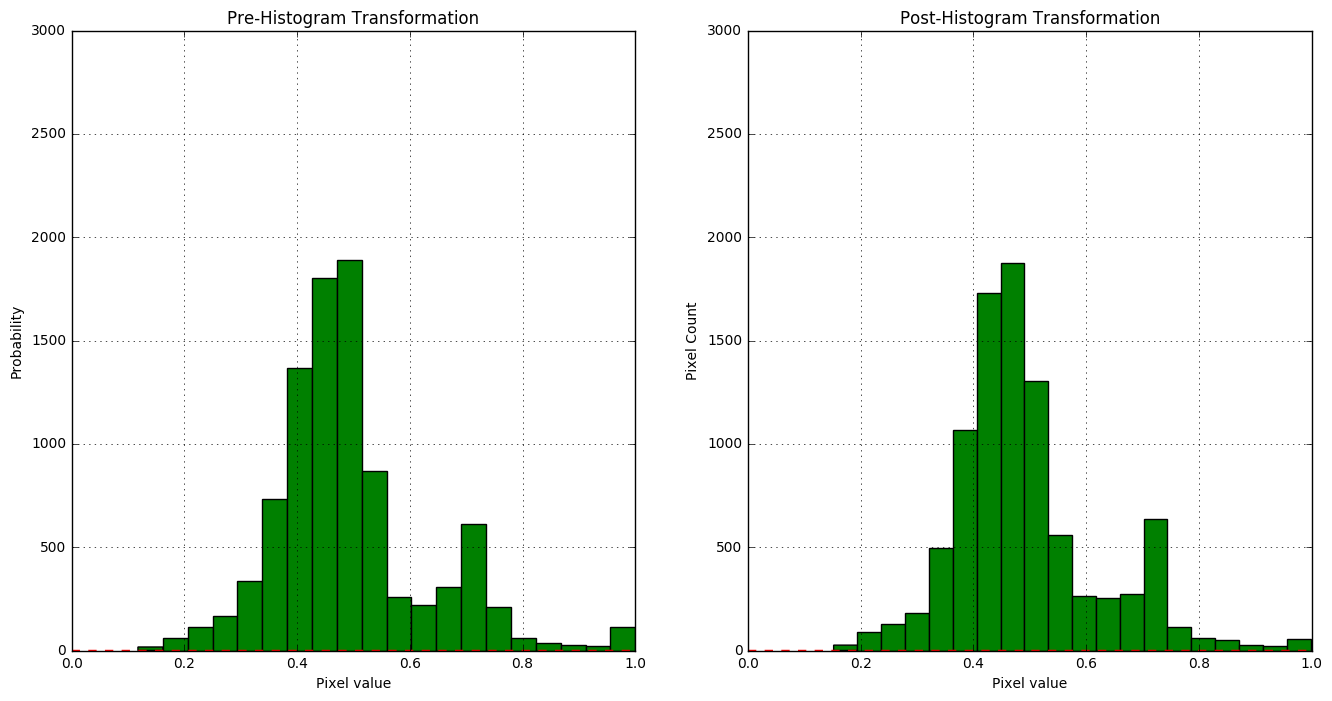

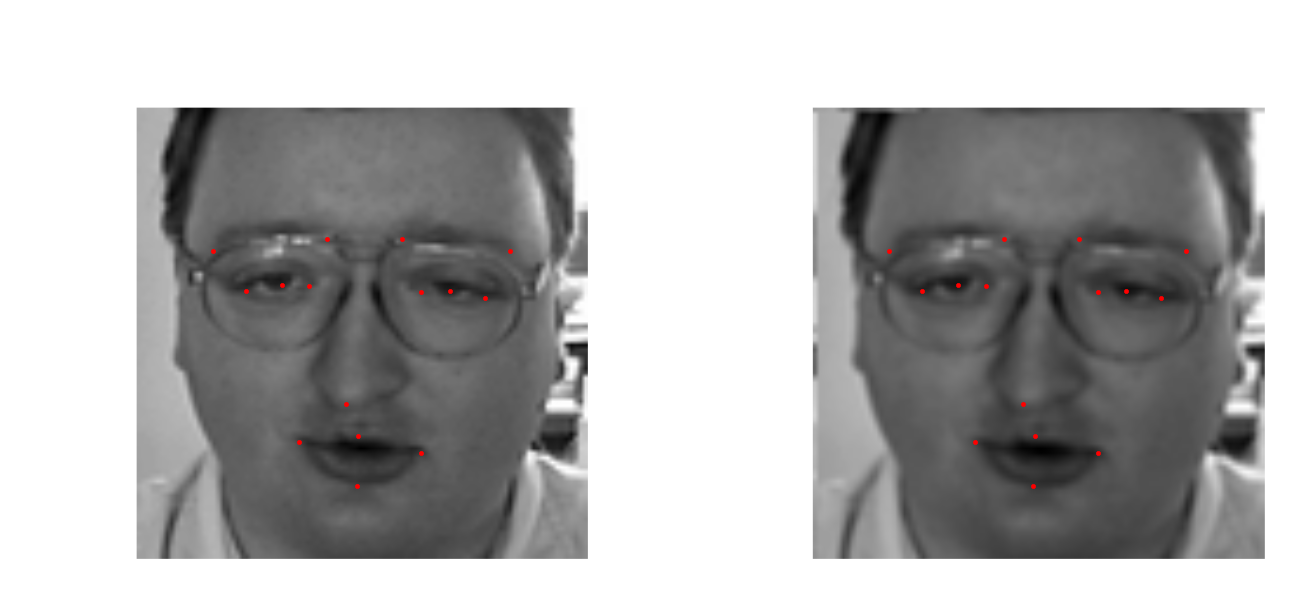

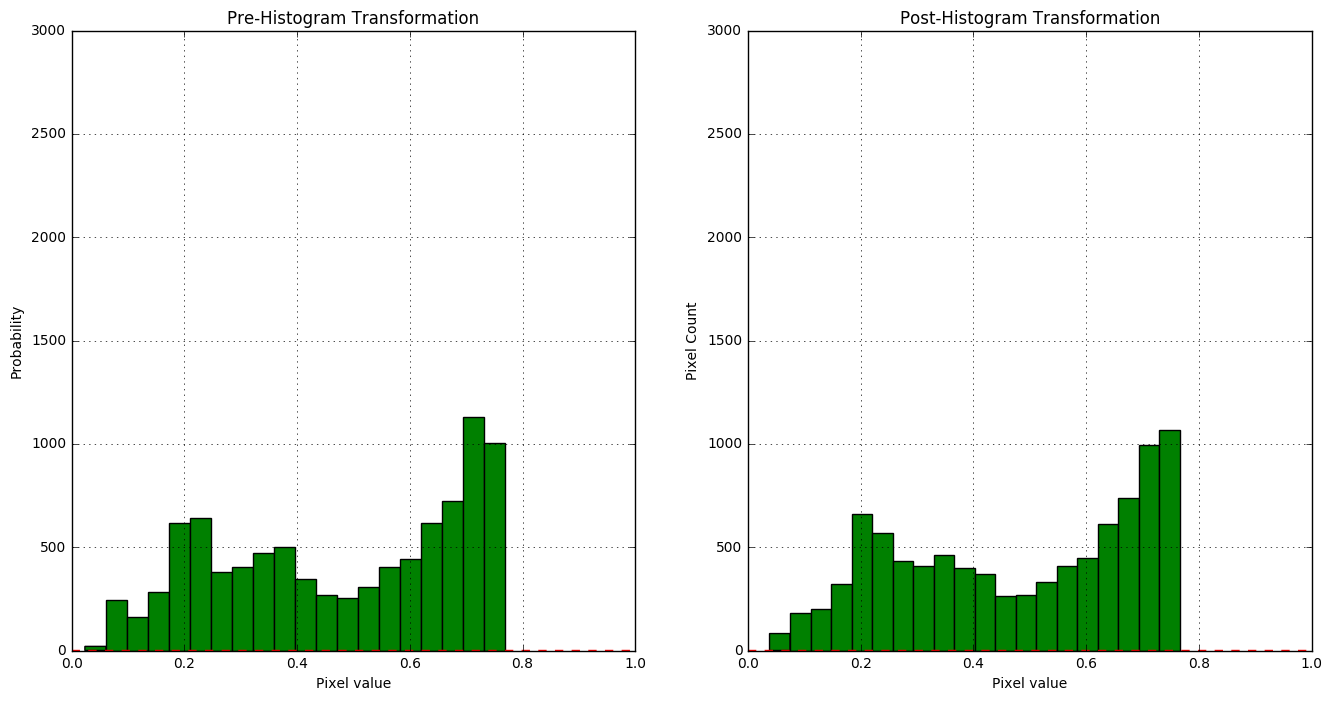

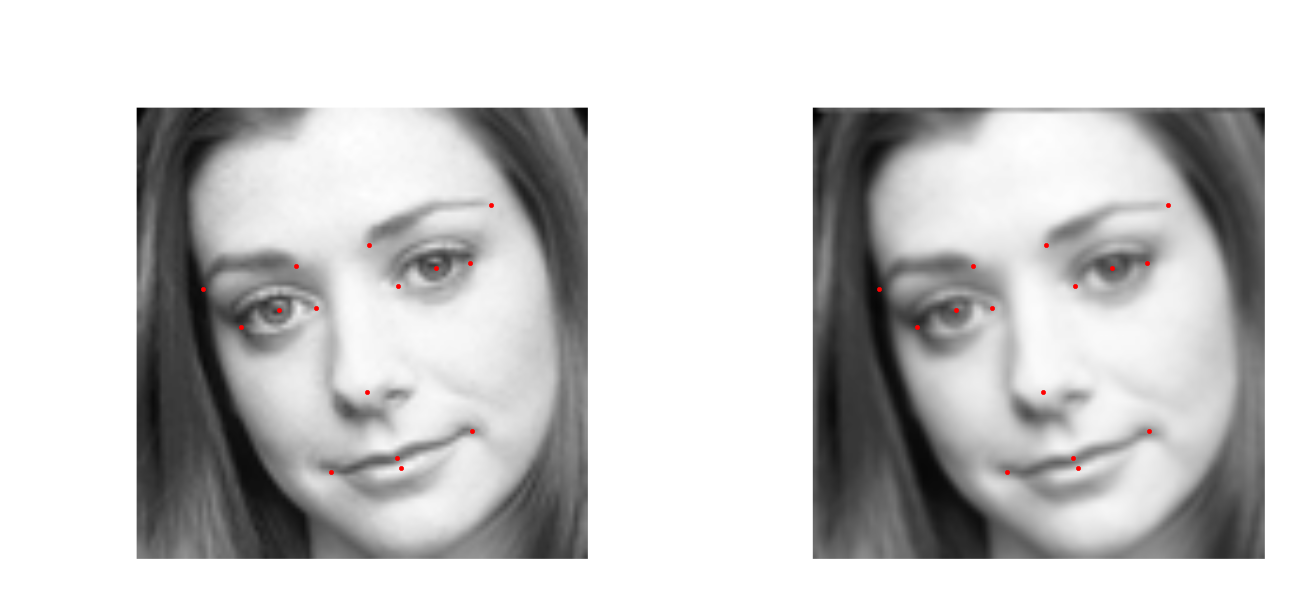

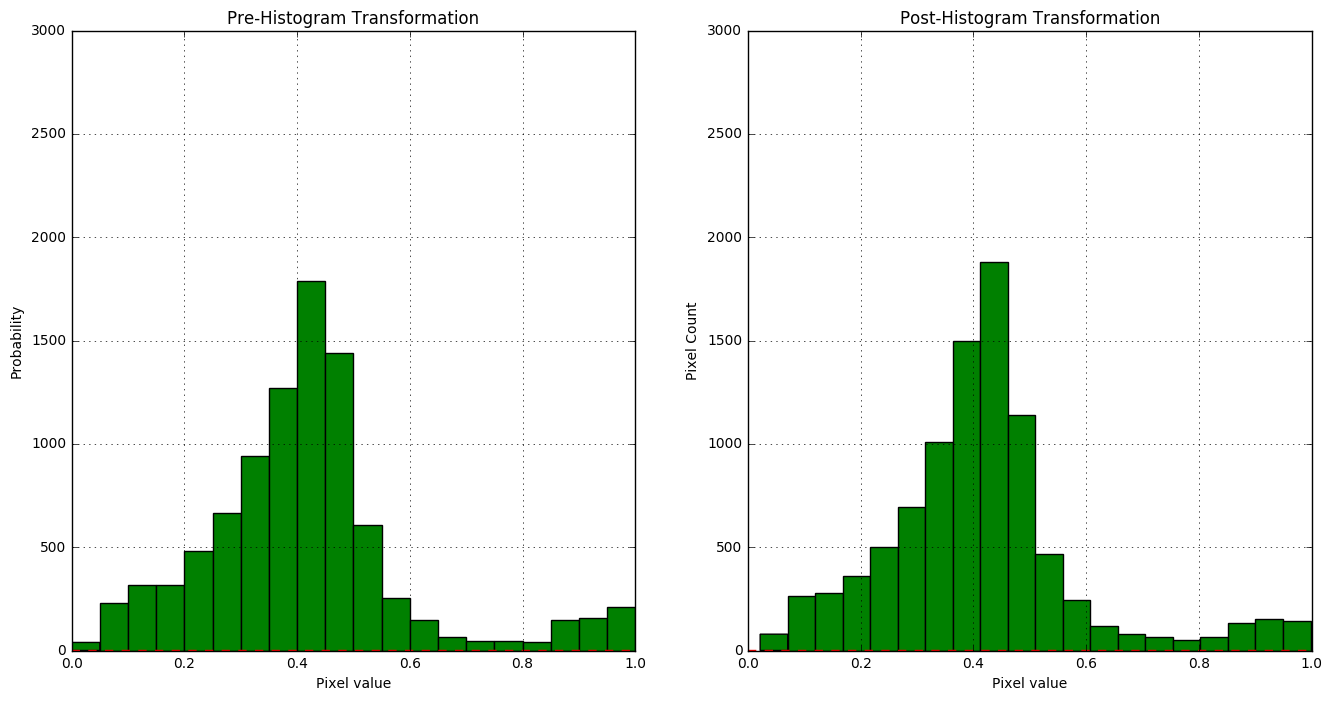

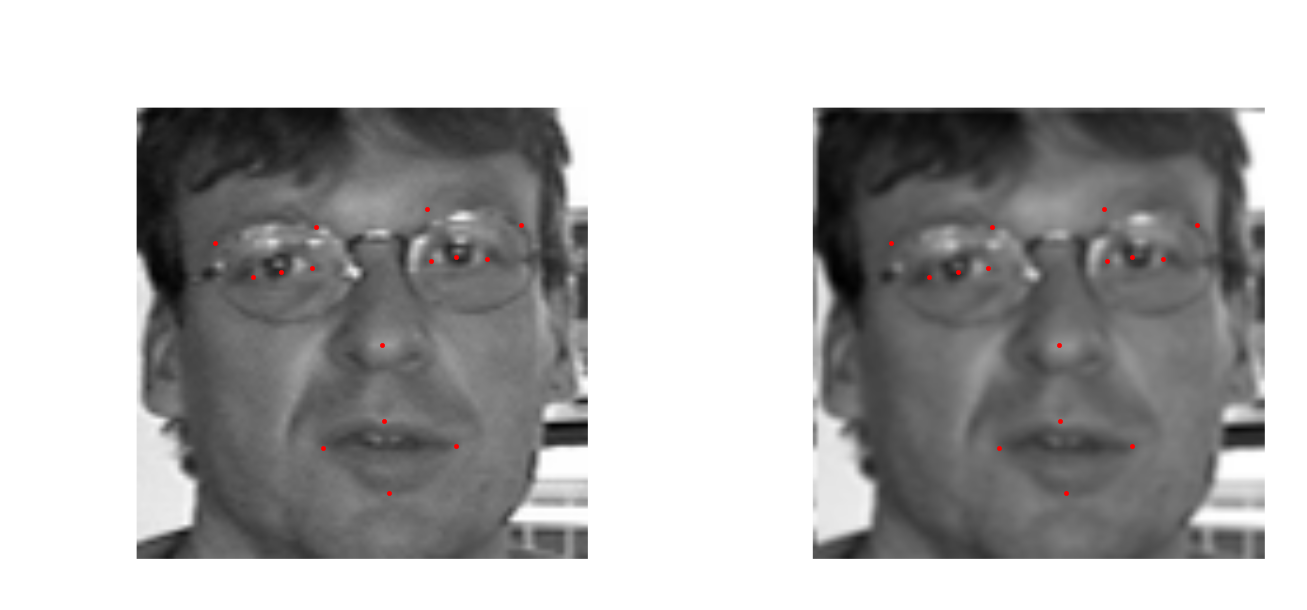

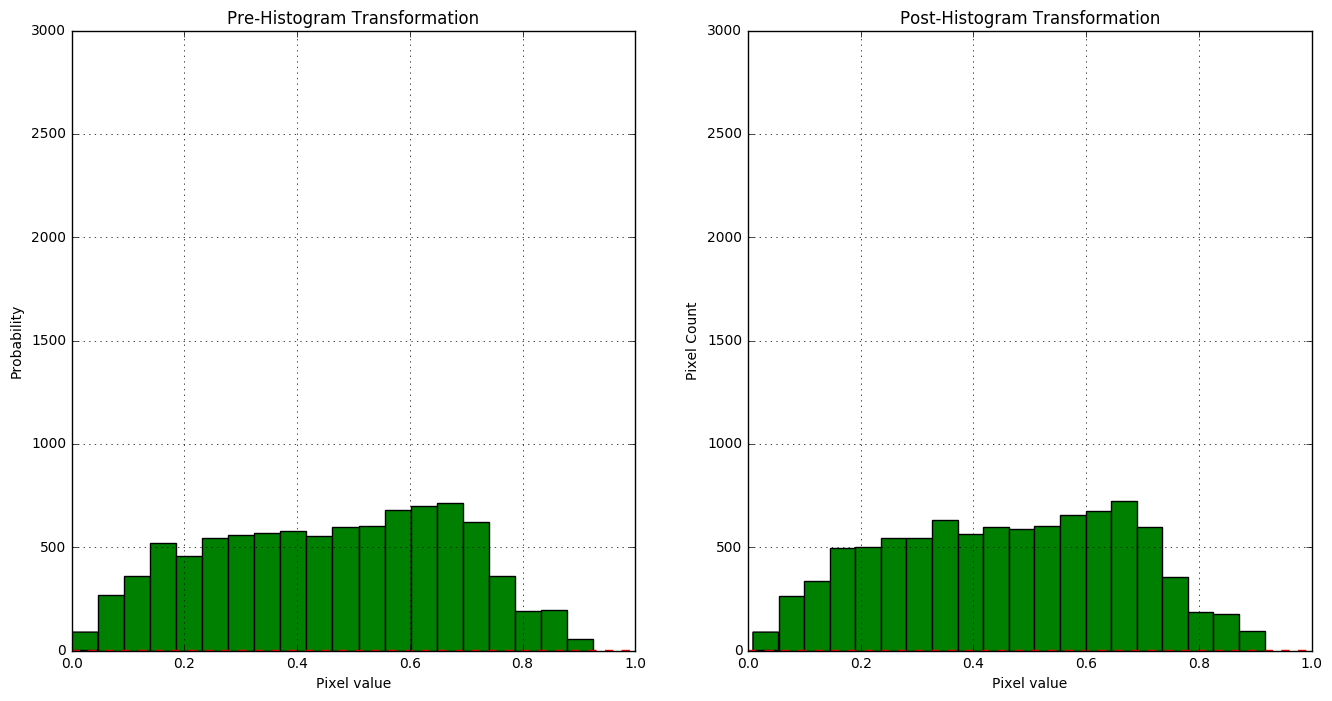

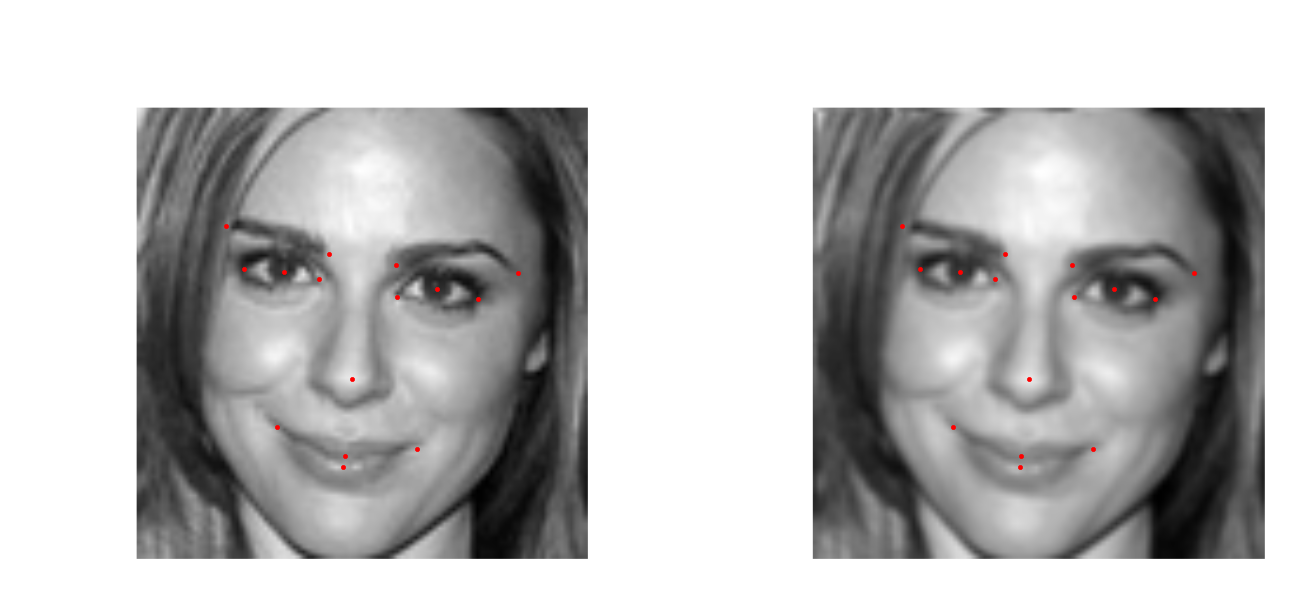

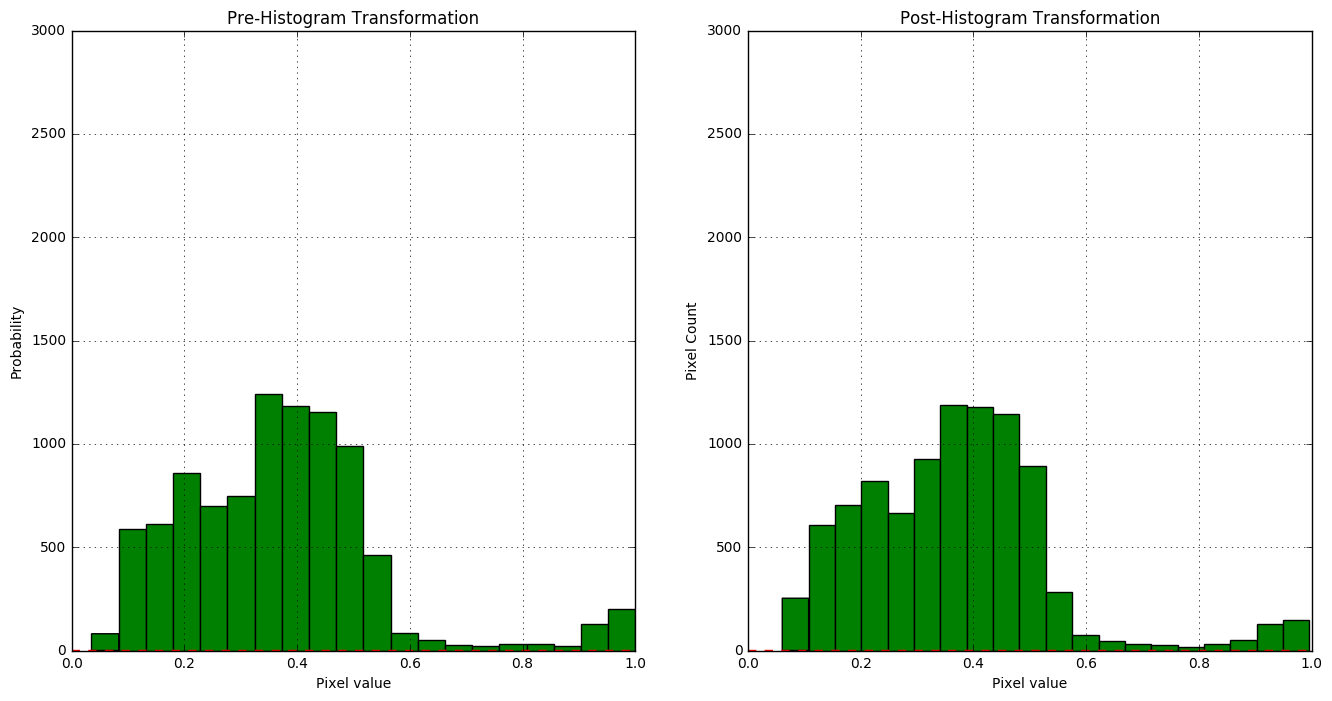

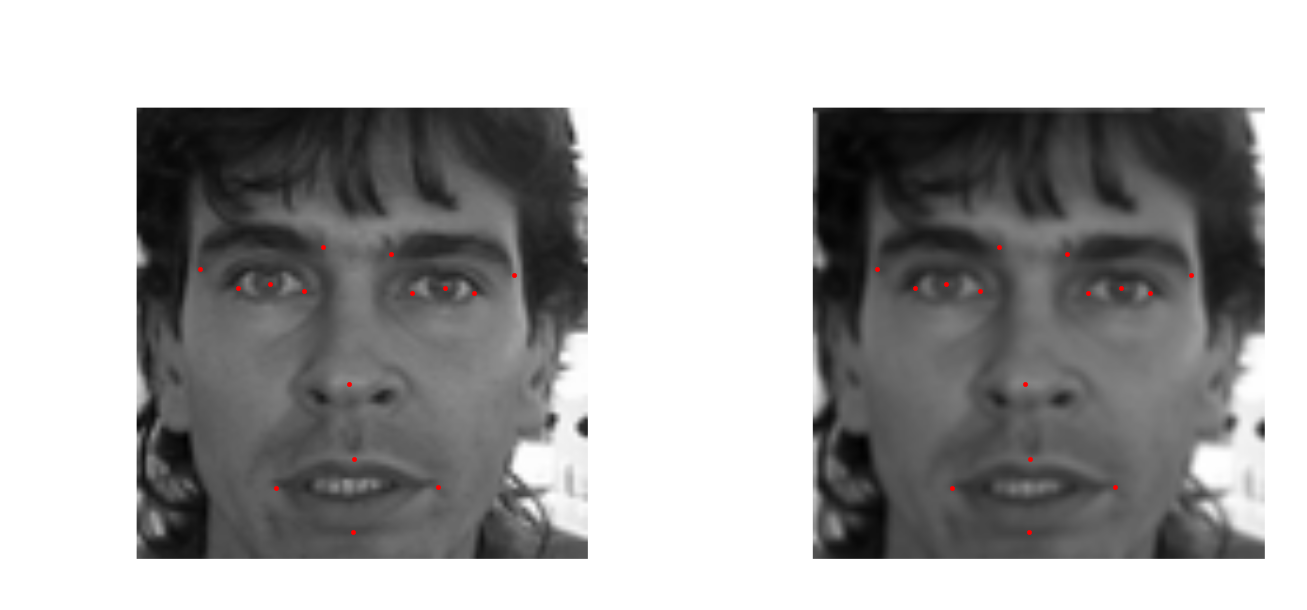

In [25]:
def gaussian_blur(origin, matrix, blur=1):
    sd = 2
    pi = np.pi
    e = np.e
    cartesian = []
    coords = []
    weights = []
    blurred_pixel = 0.0

    x = origin[0]
    y = origin[1]
    
    for i in range(-blur, blur):
        for j in range(-blur, blur):
            cartesian.append([i, j])
            try:
                if ((x - i) == 0) | ((y - j) == 0):
                    raise IndexError
                coords.append(matrix[x + i][y + j])
            except IndexError:
                coords.append(matrix[x][y])
    weights = []
    for pair in cartesian:
        x = pair[0]
        y = pair[1]
        weight = (1.0 / (2 * pi * sd ** 2)) * (e ** -((x ** 2 + y ** 2) / (2 * sd ** 2))) # 2D Gaussian function
        weights.append(weight)
    averages = [w / sum(weights) for w in weights]
    for i in range(0, len(coords)):
        blurred_pixel += coords[i] * averages[i]

    return blurred_pixel

def apply_blur(img):
    blurred_matrix = []
    matrix = img.reshape(96, 96)
    for row in range(0, len(matrix)):
        for col in range(0, len(matrix[row])):
            origin = [row, col]
            blurred_matrix.append(gaussian_blur(origin, matrix))
    return np.array(blurred_matrix).astype(np.float32)


np.random.seed(0)
sample = np.random.rand(5) * len(train_data)

for i in sample:
    before = train_data[i]
    after = apply_blur(train_data[i])
    compare_histograms(before, after)
    compare_images(before, train_labels[i], after, train_labels[i])

# Looks like everything is working well, generate the new set of data to go forward with
start = time.time()
train_blur = np.array(map(apply_blur, train_data))
print("Finished blurring train_data in %4f seconds" % (time.time() - start))

## Testing improvement with Gaussian Blur
See how the model improved by decreasing contrast


# Neural Network with 924730 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input     9216
  1  hidden     100
  2  output      30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.18526     0.03840    4.82424  0.07s
      2     0.03637     0.03000    1.21213  0.07s
      3     0.01897     0.01410    1.34491  0.07s
      4     0.01400     0.01398    1.00194  0.07s
      5     0.01292     0.01248    1.03555  0.07s
      6     0.01176     0.01167    1.00792  0.07s
      7     0.01106     0.01109    0.99722  0.07s
      8     0.01054     0.01067    0.98766  0.07s
      9     0.01013     0.01032    0.98155  0.07s
     10     0.00980     0.01003    0.97755  0.07s
     11     0.00953     0.00978    0.97409  0.07s
     12     0.00928     0.00956    0.97109  0.07s
     13     0.00906     0.00937    0.96763  0.07s
     14     0.00887     0.00919    0.96516  0.06s
     15     0.00870     0.00

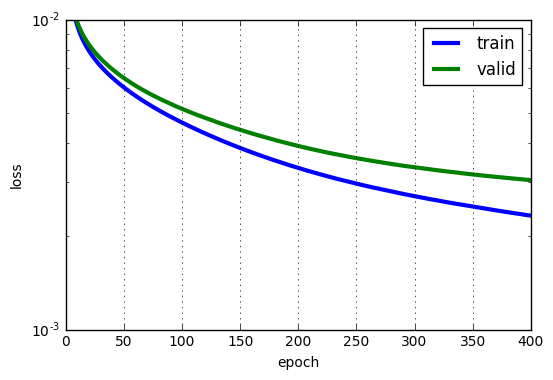

In [27]:
net4 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=400,  # we want to train this many epochs
    verbose=1,
    )

net4.fit(train_blur, train_labels)
graph_results(net4)

In [28]:
# Print RMSE
print("RMSE: %f" % (np.sqrt(0.00304) * 48))

RMSE: 2.646537


## STEP 4 : Look at Dimensionality Reduction using PCA

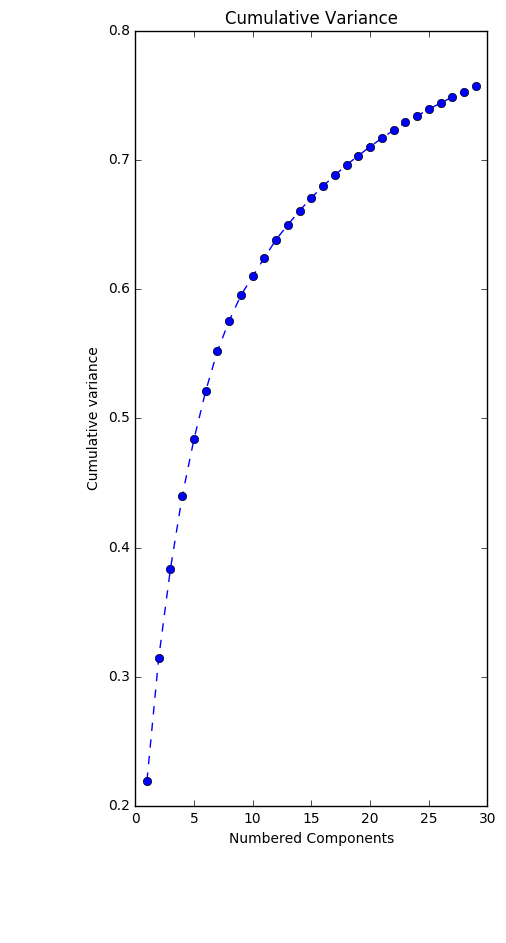

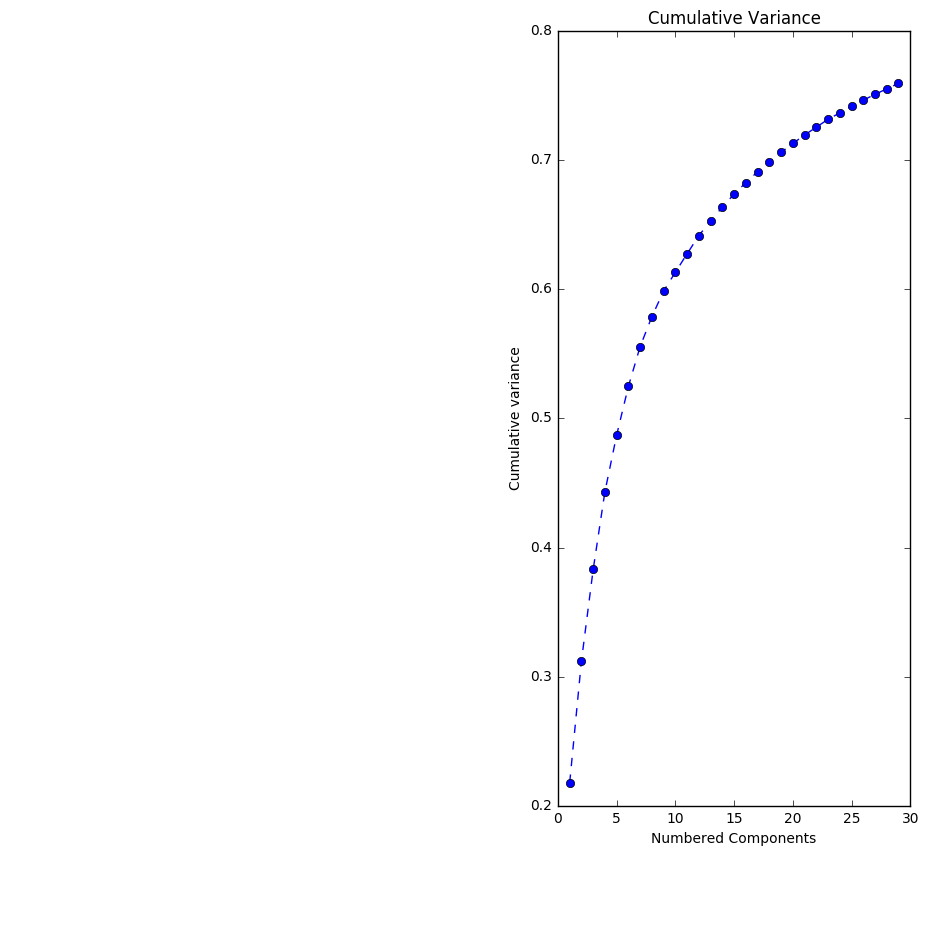

In [9]:
#  NOTE FROM CHRIS:
#  Hey Shankar, I'm leaving this one in your capable hands.  I'm still not 100% on what needs to be done with it,
#  but I figure if you model it to work similarly to the way the above functions, we'll be fine.


def P1():
### STUDENT START ###
    pca = PCA(n_components = 30, copy = True, whiten = False)
    pca.fit(train_data)
    X_data = np.arange(1, 30, 1)

    Y_data = pca.explained_variance_ratio_[0:29]
    Y_data = np.cumsum(Y_data)

    plt.figure(figsize = (10, 10))
    plt.subplot(121)
 
    plt.title("Cumulative Variance")
    plt.plot(X_data, Y_data, '--bo')
    plt.xlabel("Numbered Components")
    plt.ylabel("Cumulative variance")
    plt.annotate('90% cumulative\n variance', xy=(80, 0.9), xytext = (42, 0.9), arrowprops=dict(arrowstyle="->"))
    
    pca.fit(Shifted_X)
    X_data = np.arange(1, 30, 1)

    Y_data = pca.explained_variance_ratio_[0:29]
    Y_data = np.cumsum(Y_data)

    plt.figure(figsize = (10, 10))
    plt.subplot(122)

    plt.title("Cumulative Variance")
    plt.plot(X_data, Y_data, '--bo')
    plt.xlabel("Numbered Components")
    plt.ylabel("Cumulative variance")
    plt.annotate('90% cumulative\n variance', xy=(80, 0.9), xytext = (42, 0.9), arrowprops=dict(arrowstyle="->"))
    
    ### STUDENT END ###

P1()

Loading test data and running a prediction on it using the single layer Neural Network. Plotting the predictions to get a visual analysis of good/bad our model is.

ImageId    1783
Image      1783
dtype: int64


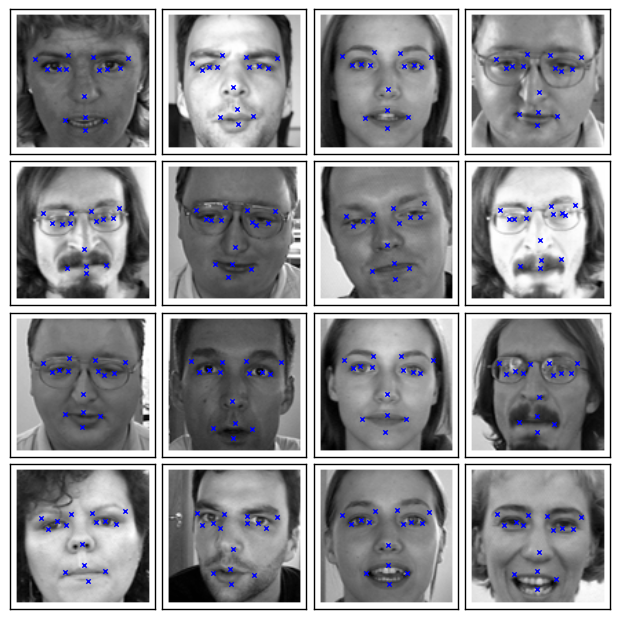

In [16]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

X, y, df, dfna = load(test=True)
y_pred = net1.predict(X)

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i*4+1], y_pred[i*4+1], ax)

plt.show()

## STEP 5: Convolutional Neural Network

Moving back to our original data, 

In [29]:
cnet1 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,
    max_epochs=400,
    verbose=1,
    )

train_data_2d = train_data.reshape(len(train_data), 1, 96, 96)
# train_labels_2d = train_labels.reshape(len(train_labels),96,96)

cnet1.fit(train_data_2d, train_labels)

# Currently on training for 10 epochs
# Training for 1000 epochs will take a while.  We'll pickle the
# trained model so that we can load it back later:
# with open('net2.pickle', 'wb') as f:
#     pickle.dump(net2, f, -1)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.12000     0.05588    2.14761  1.88s
      2     0.02288     0.00868    2.63604  1.86s
      3     0.00837     0.00705    1.18611  1.86s
      4     0.00704     0.00647    1.08753  1.85s
      5     0.00660     0.00621    1.06260  1.85s
      6     0.00638     0.00601    1.06088  1.86s
      7     0.00619     0.00584    1.05957  1.85s
      8     0.00604     0.00570    1.05900  1.85s
      9     0.00590     0.00558    1.05877  1.85s
     10     0.00578     0.00546    1.05871  1.86s
     11     0.00568     0.00536    1.05878  1.86s
     12     0.00558

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fa9a20c3a90>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7fa9a20c3990>,
     check_input=True, conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_scores=None,
     hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=400, more_params={},
     objective=<function objective at 0x7fa9a20ce1

In [30]:
# Print RMSE
print("RMSE: %f" % (np.sqrt(0.00276) * 48))

RMSE: 2.521714


## Graph results for Convolutional Neural Net

Plot how the training did for the 10 epochs. This plot will be interesting when we run it for 400 epochs as we did for Neural Networks.

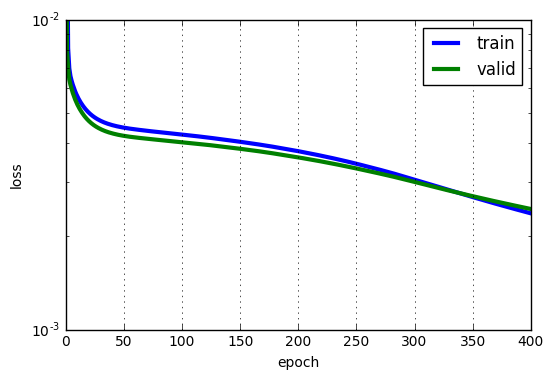

In [46]:
graph_results(cnet1)

ImageId    1783
Image      1783
dtype: int64
ImageId    1783
Image      1783
dtype: int64


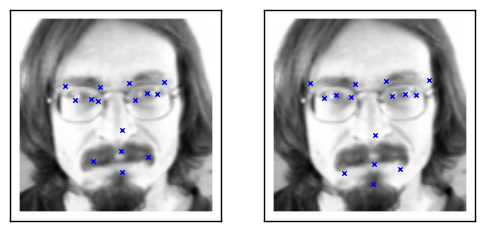

In [24]:
sample1 = load(test=True)[0][100:101]
sample2 = load2d(test=True)[0][100:101]
y_pred1 = net1.predict(sample1)[0]
y_pred2 = net2.predict(sample2)[0]

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(sample1[0], y_pred1, ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(sample2[0], y_pred2, ax)
plt.show()

## Update learning rates
Convolutional Net 2 - instead of using static learning rates and momentums, we can use lasagne's "on epoch finshed" call to take a function that will adjust our learning rates and momentum dyanimcally after each epoch. Nesterov's momentum add's the gradient at the current point, plus the velocity, which provides some look ahead in the data to improve optimization. By increasing momentum during training, Geoffrey Hitton has shown this can imrove optimization.

#### ref: http://www.cs.toronto.edu/~hinton/absps/momentum.pdf

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.06404     0.00996    6.43205  1.88s
      2     0.00834     0.00654    1.27572  1.87s
      3     0.00641     0.00572    1.12072  1.87s
      4     0.00578     0.00528    1.09408  1.86s
      5     0.00541     0.00500    1.08231  1.86s
      6     0.00516     0.00480    1.07564  1.86s
      7     0.00498     0.00465    1.07068  1.86s
      8     0.00485     0.00455    1.06683  1.87s
      9     0.00475     0.00447    1.06343  1.86s
     10     0.00468     0.00441    1.06057  1.86s
     11     0.00463     0.00437    1.05830  1.86s
     12     0.00458

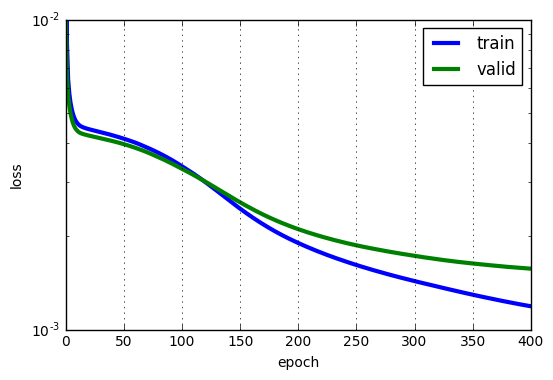

In [33]:
#in order to change the learning rates and momemtum, we need to make it a shared variable in theano.
#http://lasagne.readthedocs.io/en/latest/user/layers.html
import theano

def float32(var):
    return np.cast['float32'](var)

#This adjust variable call was modified from Danile Nouri's tutorial.
class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            #create evenly spaced values based on the starting and stopping values, divided evenly by the num of epochs
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)
        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)


cnet2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    
    regression=True,
    max_epochs=400,
    verbose=1,
    )

start_time = time.time()
cnet2.fit(train_data_2d, train_labels)
print('CNN training completed in',(time.time()-start_time))

# Training for 1000 epochs will take a while.  We'll pickle the
# trained model so that we can load it back later:
# with open('cnet2.pickle', 'wb') as f:
#     pickle.dump(cnet2, f, -1)
    
graph_results(cnet2)

In [35]:
# Print RMSE
print("RMSE: %f" % (np.sqrt(0.00157) * 48))

RMSE: 1.901915


## Continue tweaking

The net above performed really well.  Let's see if we can continue to improve by adding more layers

# Neural Network with 13489330 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  conv4    256x10x10
  8  pool4    256x10x10
  9  hidden5  500
 10  hidden6  500
 11  hidden7  500
 12  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.10545     0.02013    5.23870  2.25s
      2     0.01084     0.00679    1.59597  2.25s
      3     0.00601     0.00529    1.13789  2.25s
      4     0.00538     0.00495    1.08537  2.24s
      5     0.00516     0.00481    1.07249  2.25s
      6     0.00503     0.00471    1.06869  2.25s
      7     0.00494     0.00463    1.06627  2.25s
      8     0.00486     0.00457    1.06496  2.25s
      9     0.00480     0.00451    1.06386  2.25s
     10     0.00475     0.00447    1.06300  2.25s
  

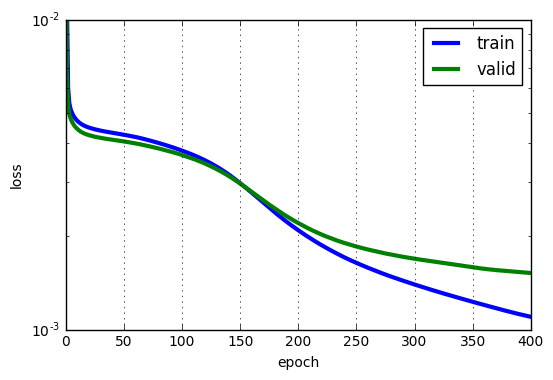

In [58]:
cnet3 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('conv4', layers.Conv2DLayer),
        ('pool4', layers.MaxPool2DLayer),
        ('hidden5', layers.DenseLayer),
        ('hidden6', layers.DenseLayer),
        ('hidden7', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    conv4_num_filters=256, conv4_filter_size=(2, 2), pool4_pool_size=(1, 1),
    hidden5_num_units=500, hidden6_num_units=500, hidden7_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    
    regression=True,
    max_epochs=400,
    verbose=1,
    )

cnet3.fit(train_data_2d, train_labels)
graph_results(cnet3)

In [60]:
# Print RMSE
print("RMSE: %f" % (np.sqrt(0.00152) * 48))

RMSE: 1.871385


## Using transformed data in the convolutional neural net.

Cnet 3 was the best run yet, but it was very slow compared to cnet2, which is almost as accurate. So to test the transformed data, we'll use the cnet2.

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.05888     0.01006    5.85353  1.89s
      2     0.00830     0.00657    1.26292  1.86s
      3     0.00639     0.00565    1.13036  1.86s
      4     0.00570     0.00516    1.10369  1.86s
      5     0.00529     0.00485    1.09106  1.86s
      6     0.00503     0.00465    1.08251  1.86s
      7     0.00486     0.00451    1.07687  1.87s
      8     0.00474     0.00442    1.07223  1.87s
      9     0.00466     0.00436    1.06881  1.87s
     10     0.00460     0.00431    1.06622  1.87s
     11     0.00456     0.00428    1.06414  1.86s
     12     0.00453

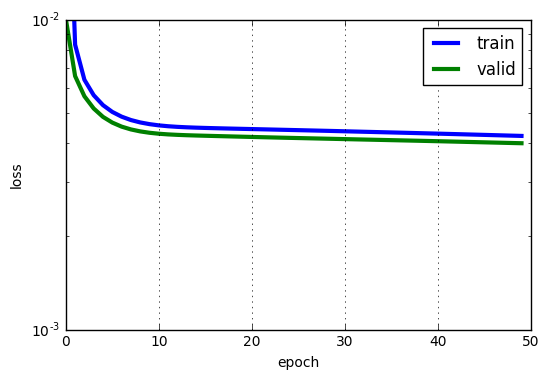

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.05507     0.00964    5.71493  1.89s
      2     0.00733     0.00582    1.26061  1.88s
      3     0.00588     0.00526    1.11892  1.87s
      4     0.00546     0.00499    1.09595  1.87s
      5     0.00523     0.00481    1.08761  1.87s
      6     0.00506     0.00468    1.08192  1.87s
      7     0.00494     0.00458    1.07844  1.87s
      8     0.00484     0.00450    1.07560  1.87s
      9     0.00477     0.00444    1.07375  1.87s
     10     0.00470     0.00439    1.07240  1.87s
     11     0.00465     0.00434    1.07130  1.87s
     12     0.00460

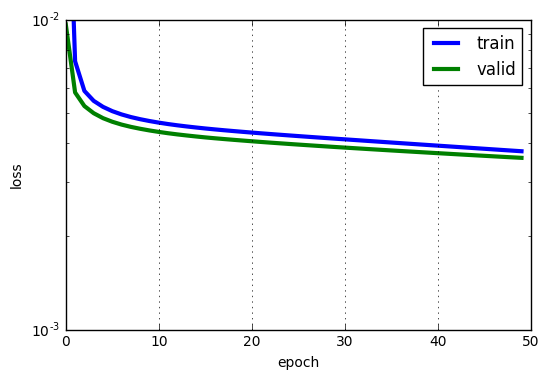

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.04547     0.00796    5.71177  1.89s
      2     0.00637     0.00556    1.14620  1.87s
      3     0.00559     0.00526    1.06275  1.86s
      4     0.00537     0.00511    1.05181  1.86s
      5     0.00524     0.00499    1.05037  1.86s
      6     0.00513     0.00489    1.04972  1.86s
      7     0.00504     0.00480    1.04993  1.86s
      8     0.00496     0.00473    1.04970  1.86s
      9     0.00489     0.00466    1.04972  1.86s
     10     0.00483     0.00460    1.04984  1.86s
     11     0.00477     0.00455    1.04964  1.86s
     12     0.00472

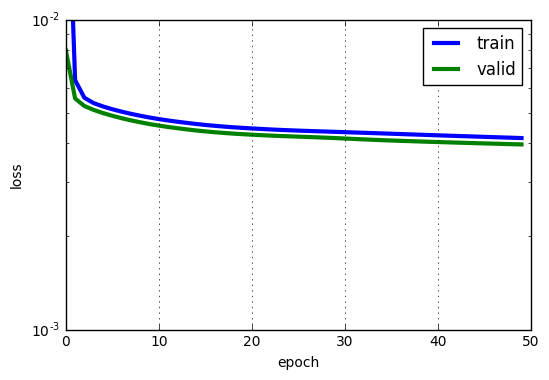

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.08655     0.01415    6.11610  1.87s
      2     0.00856     0.00558    1.53469  1.86s
      3     0.00548     0.00497    1.10182  1.86s
      4     0.00509     0.00474    1.07522  1.86s
      5     0.00493     0.00462    1.06737  1.87s
      6     0.00483     0.00454    1.06373  1.86s
      7     0.00476     0.00448    1.06211  1.86s
      8     0.00470     0.00443    1.06095  1.86s
      9     0.00466     0.00439    1.06029  1.86s
     10     0.00462     0.00436    1.05978  1.86s
     11     0.00459     0.00433    1.05935  1.86s
     12     0.00456

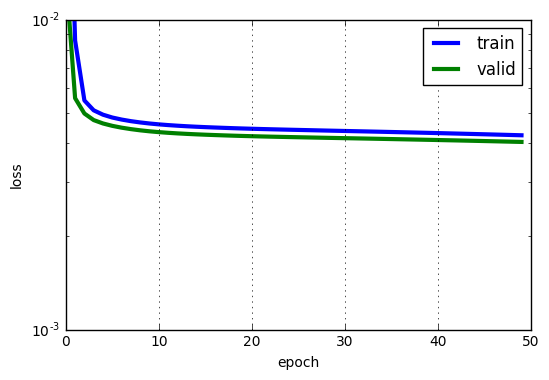

In [48]:
#  Move transformations into 2d
stretch2d = train_stretched.reshape(len(train_stretched), 1, 96, 96)
shift2d = train_shift.reshape(len(train_shift), 1, 96, 96)
blur2d = train_blur.reshape(len(train_blur), 1, 96, 96)


cnet2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    
    regression=True,
    max_epochs=50,
    verbose=1,
    )

cnet2.fit(train_data_2d, train_labels)
graph_results(cnet2)

cnet2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    
    regression=True,
    max_epochs=50,
    verbose=1,
    )

cnet2.fit(stretch2d, train_labels)
graph_results(cnet2)

cnet2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    
    regression=True,
    max_epochs=50,
    verbose=1,
    )

cnet2.fit(shifth2d, train_labels)
graph_results(cnet2)

cnet2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    
    regression=True,
    max_epochs=50,
    verbose=1,
    )

cnet2.fit(blur2d, train_labels)
graph_results(cnet2)



In [21]:
# Transforming train dataset by applying stretch/shift histogram
# and gaussian blur.
transformed_data= np.array(map(stretch_histogram, train_data))
transformed_data= np.array(map(shift_histogram, transformed_data))
transformed_data= np.array(map(apply_blur, transformed_data))

(2140, 9216)


# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.04386     0.00647    6.77928  1.87s
      2     0.00566     0.00503    1.12473  1.86s
      3     0.00514     0.00485    1.05989  1.86s
      4     0.00502     0.00477    1.05228  1.86s
      5     0.00495     0.00471    1.05121  1.86s
      6     0.00490     0.00467    1.04987  1.86s
      7     0.00485     0.00463    1.04939  1.86s
      8     0.00482     0.00459    1.04895  1.86s
      9     0.00478     0.00456    1.04867  1.86s
     10     0.00475     0.00453    1.04853  1.86s
     11     0.00472     0.00450    1.04835  1.86s
     12     0.00470

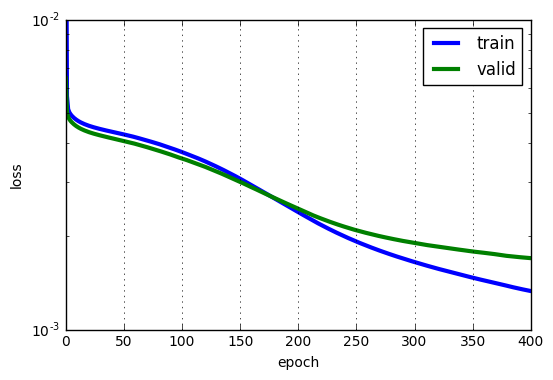

In [24]:
transformed_data_2d = transformed_data.reshape(len(transformed_data), 1, 96, 96)

cnet5 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    
    regression=True,
    max_epochs=400,
    verbose=1,
    )

cnet5.fit(transformed_data_2d, train_labels)
graph_results(cnet5)

## Keypoints detection in test data

In [32]:
# Transforming test dataset by applying stretch/shift histogram
# and gaussian blur.
test_transformed= np.array(map(stretch_histogram, test_data))
test_transformed= np.array(map(shift_histogram, test_transformed))
test_transformed= np.array(map(apply_blur, test_transformed))

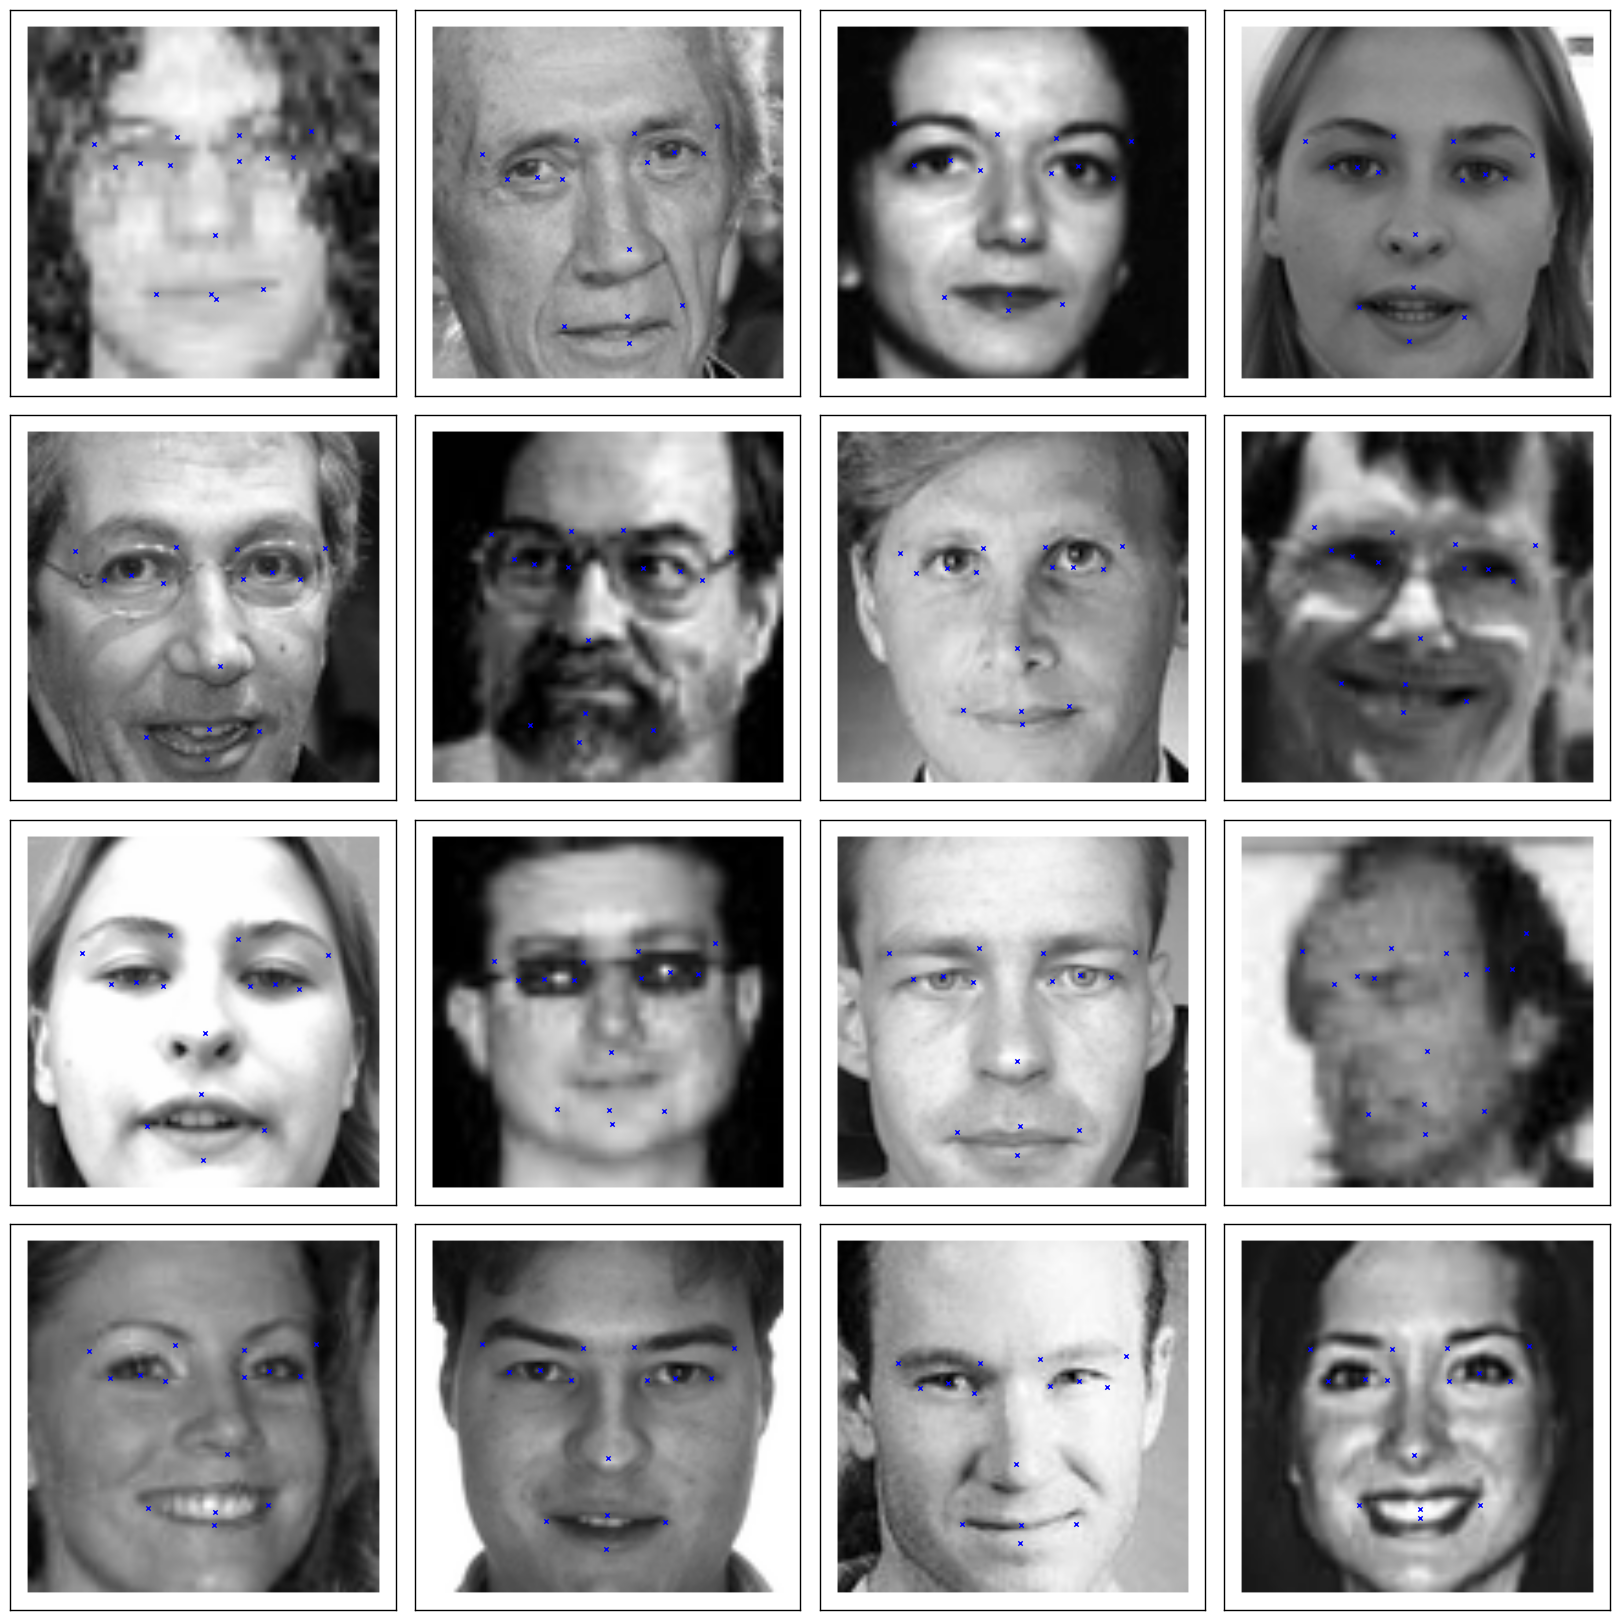

In [34]:
from random import randint

test_data_2d = test_transformed.reshape(len(test_transformed), 1, 96, 96)
test_pred = cnet5.predict(test_data_2d) 

fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    test_idx = randint(0, len(test_data))
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(test_data[test_idx], test_pred[test_idx], ax)

plt.show()